<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import os

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
elif False:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

TF version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Found GPU at: /device:GPU:0


In [3]:
import itertools
import os

import numpy as np
pi = np.pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import tensorflow as tf
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator
from scipy.linalg import toeplitz

!pip install --quiet tensorfont
!pip install --quiet fonttools
!pip install --quiet --upgrade fontParts
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
import fontParts
import extractor
import defcon
from ufo2ft import compileOTF

from tensorfont import Font

print("✓ Dependencies imported.")

     |████████████████████████████████| 890kB 10.3MB/s 
     |████████████████████████████████| 798kB 8.9MB/s 
     |████████████████████████████████| 163kB 8.2MB/s 
     |████████████████████████████████| 235kB 15.3MB/s 
     |████████████████████████████████| 133kB 20.4MB/s 
     |████████████████████████████████| 430kB 24.7MB/s 
     |████████████████████████████████| 133kB 10.1MB/s 
     |████████████████████████████████| 358kB 9.6MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
     |████████████████████████████████| 184kB 20.9MB/s 
✓ Dependencies imported.


In [4]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [5]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
#glyph_char_list = "abgjqrst"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
#glyph_char_list = "abc"

# ==== Create Font ====
factor = 0.8 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

batch_size = 1
sample_distance_deltas = [-2, 0, 2]
sample_distance_factors = [.3, 1., 4.4]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 5
n_v1_orientations = 4
n_v4_scales = 5

Box size: 63 × 129


In [6]:
def get_sigmas(skip_scales=0):
    sigmas = []
    for s in range(n_v1_scales):
        min_sigma = 0.7
        max_sigma = box_width / 15
        sigmas.append((max_sigma - min_sigma) * (s + skip_scales)**2 / (n_v1_scales - 1)**2 + min_sigma)
        #sigmas.append((max_sigma - min_sigma) * s / n_v1_scales + min_sigma)
    return np.array(sigmas)

print("Spatial frequency scales:", get_sigmas())

def get_v1_filter_bank(skip_scales, display_filters=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[ np.cos(pi*oi/n_v1_orientations), np.sin(pi*oi/n_v1_orientations)],
                             [-np.sin(pi*oi/n_v1_orientations), np.cos(pi*oi/n_v1_orientations)]])
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = np.mgrid[-hh:hh, -bw:bw].astype(np.float32)
        y += 0.5 # 0 if box_height % 2 == 0 else 0.5
        x += 0.5 # 0 if box_width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

    def get_filter(s, theta):
        x, y = rotated_mgrid(theta)

        # To minimize ringing etc., we create the filter as is, then run it through the DFT.

        # First derivative (odd filter/up-down)
        d1_space = np.exp(-(x**2+y**2)/(2*s**2))*x/(2*pi*s**4)
        d1_relu_sum = np.sum(d1_space * (d1_space > 0))
        d1 = np.fft.fft2(np.fft.ifftshift(d1_space + 1j * np.zeros_like(d1_space)))

        # Second derivative (even filter/mexican hat):
        s2 = s * .85 # To make them about the same width
        d2_space = np.exp(-(x**2+y**2)/(2*s2**2))/(2*pi*s2**4) - np.exp(-(x**2+y**2)/(2*s2**2))*x**2/(2*pi*s2**6)
        d2_relu_sum = np.sum(d2_space * (d2_space > 0))
        d2 = (d1_relu_sum / d2_relu_sum) * np.fft.fft2(np.fft.ifftshift(d2_space + 1j * np.zeros_like(d2_space)))

        return (d1 + 1j*d2) / (5 * np.max(tf.abs(d1+1j*d2))) # Max output should be about 0.2, which leaves lots of flexibility for the HRA later

    filter_bank = np.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width)).astype(np.complex64)

    if display_filters:
        sizediv = 30
        fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))

    sigmas = get_sigmas()
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter(sigma, o)
            if display_filters:
                mx = np.max(np.abs(np.imag(np.fft.ifft2(f))))
                ax[s*2, o].imshow(np.real(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2, o].set_aspect("auto")
                ax[s*2, o].set_yticklabels([])
                ax[s*2+1, o].imshow(np.imag(np.fft.fftshift(np.fft.ifft2(f))), cmap="RdBu", vmin=-mx, vmax=mx)
                ax[s*2+1, o].set_aspect("auto")
                ax[s*2+1, o].set_yticklabels([])
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()

    return filter_bank.astype(np.complex64)

filter_bank = get_v1_filter_bank(0, display_filters=False)


def apply_filter_bank(input_image, filter_bank):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    bdsohw_input_image = input_image[None, None, None, None, :, :]

    # pad image to filter size, which is 2*box_height, 2*box_width (to prevent too much wrapping)
    padded_input = tf.pad(bdsohw_input_image, [[0, 0], [0, 0], [0, 0], [0, 0],
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

    input_in_freqdomain = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(padded_input, tf.zeros_like(padded_input))))

    padded_result = tf.signal.ifft2d(input_in_freqdomain * filter_bank[None, None, :, :, :, :])

    presult = tf.signal.fftshift(padded_result[0, 0, :, :, :, :], [2, 3])

    return presult[:, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]

Spatial frequency scales: [0.7     1.19375 2.675   5.14375 8.6    ]


100%|██████████| 26/26 [00:00<00:00, 2098.81it/s]

  ✓ 26 glyphs rendered.



100%|██████████| 26/26 [00:00<00:00, 40966.15it/s]

  ✓ 26 glyphs measured.



100%|██████████| 26/26 [00:02<00:00, 10.74it/s]

  ✓ 26 glyphs filtered.


Scale: 0


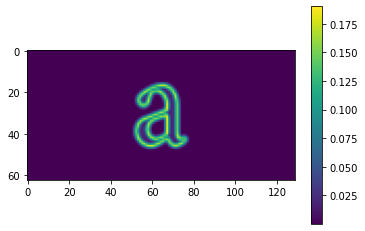

Scale: 1


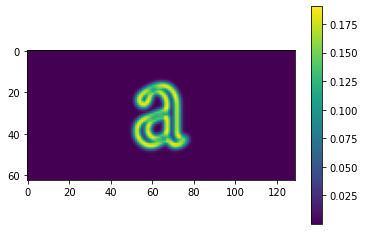

Scale: 2


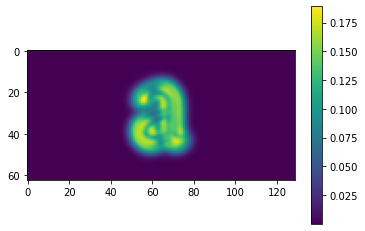

Scale: 3


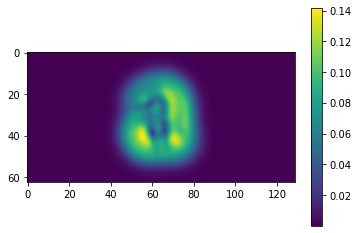

Scale: 4


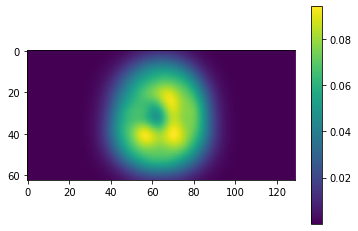

100%|██████████| 26/26 [00:00<00:00, 120.03it/s]

  ✓ 676 pairs assembled.

  ✓ Dataset ready.


In [7]:
# 1. Render glyphs

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

def get_v1_response(glyph_image):
    """Returns a np.array of shape [n_v1_scales, n_v1_orientations, box_height, box_width] and type complex64,
    containing the local responses to the V1 filter bank (after inverse Fourier transform, i.e. in the spatial domain)."""
    with tf.device("/gpu:0"):
        filtered = apply_filter_bank(glyph_image, filter_bank)
    return filtered

glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)
glyph_v1_responses = {c: get_v1_response(glyph_images[c]) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs filtered.", flush=True)

# 1a. Show an example of filtered glyphs
for si in range(n_v1_scales):
    print("Scale:", si)
    plt.imshow(np.sum(np.abs(glyph_v1_responses["a"][si, :, :, :]), (0)))
    plt.colorbar()
    plt.show()

# 2. Assemble pairs

def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance * np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)
    
left_images = []
right_images = []
left_v1_responses = []
right_v1_responses = []
left_translations = []
right_translations = []

for c1 in tqdm(glyph_char_list):
    for c2 in glyph_char_list:
        left_images.append(glyph_images[c1])
        right_images.append(glyph_images[c2])
        left_v1_responses.append(glyph_v1_responses[c1])
        right_v1_responses.append(glyph_v1_responses[c2])

        lt, rt = get_pair_translations(c1, c2, sample_distance_deltas) #, sample_distance_factors)
        left_translations.append(lt)
        right_translations.append(rt)

print("  ✓", len(glyph_char_list)**2, "pairs assembled.")

# 3. Set up generator to yield pairs, and wrap generator in a tf.Dataset

def return_pair():
    i = 0
    while i < len(left_images):
        yield {
            "left_image": left_images[i],
            "right_image": right_images[i],
            "left_v1_response": left_v1_responses[i],
            "right_v1_response": right_v1_responses[i],
            "left_translations": left_translations[i],
            "right_translations": right_translations[i],
        }
        i = (i + 1) % len(left_images)

dataset = tf.data.Dataset.from_generator(
     return_pair,
     {
      "left_image": tf.float32,
      "right_image": tf.float32,
      "left_v1_response": tf.complex64,
      "right_v1_response": tf.complex64,#
      "left_translations": tf.int32,
      "right_translations": tf.int32,
     },
     {
      "left_image": tf.TensorShape([box_height, box_width]),
      "right_image": tf.TensorShape([box_height, box_width]),
      "left_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "right_v1_response": tf.TensorShape([n_v1_scales, n_v1_orientations, box_height, box_width]),
      "left_translations": tf.TensorShape([n_sample_distances,]),
      "right_translations": tf.TensorShape([n_sample_distances,])
     },
)

print("\n  ✓ Dataset ready.")

In [8]:
# 4. Apply horizontal translations in the dataset

def translate_4d_image(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, height, width>
    """

    images = tf.tile(input_image[:, :, :, :, None], [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], left, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], right, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=3) # pad on axis 3 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0] # sohw
        shift = image_and_shift[1] # 
        return image[:, :, :, left-shift:left-shift+input_image.shape[3]] # positive shift: left-shift

    result = tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("sohwd->dsohw", padded_images), translations),
        dtype=images.dtype)

    # Manually ensure that the width-dimension hasn't changed
    s = list(result.shape)
    s[-1] = box_width
    result.set_shape(s)

    return result

def apply_translations(d):
    d["left_image"] = translate_4d_image(d["left_image"][None, None, :, :], d["left_translations"])[:, 0, 0, :, :]
    d["right_image"] = translate_4d_image(d["right_image"][None, None, :, :], d["right_translations"])[:, 0, 0, :, :]
    d["left_v1_response"] = translate_4d_image(d["left_v1_response"], d["left_translations"])
    d["right_v1_response"] = translate_4d_image(d["right_v1_response"], d["right_translations"])
    del d["left_translations"]
    del d["right_translations"]
    return (d, 0.)  # The zero here doesn't do anything and is just to make Keras happy, because model.fit expects a dataset of 2-tuples where the second entry is the target value.

translated_dataset = dataset.map(apply_translations)

print("dataset shapes:", translated_dataset.element_spec)

dataset shapes: ({'left_image': TensorSpec(shape=(3, 63, 129), dtype=tf.float32, name=None), 'right_image': TensorSpec(shape=(3, 63, 129), dtype=tf.float32, name=None), 'left_v1_response': TensorSpec(shape=(3, 5, 4, 63, 129), dtype=tf.complex64, name=None), 'right_v1_response': TensorSpec(shape=(3, 5, 4, 63, 129), dtype=tf.complex64, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))


Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: -1.7308['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf_op_layer_strided_slice_22', 'tf_op_layer_strided_slice_23', 'tf_op_layer_Sub_22', 'tf_op_layer_Sub_23', 'tf_op_layer_stack_5', 'tf_op_layer_worst_violation_5', 'left_image', 'right_image', 'tf_op_layer_total_violation_5']
[<tf.Tensor 'left_v1_response_5:0' shape=(None, 3, 5, 4, 63, 129) dtype=complex64>, <tf.Tensor 'right_v1_response_5:0' shape=(None, 3, 5, 4, 63, 129) dtype=complex64>, <tf.Tensor 'left_i

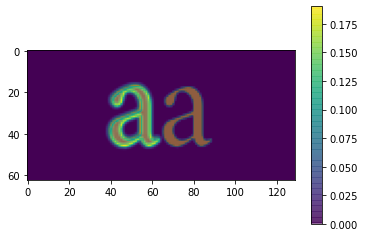

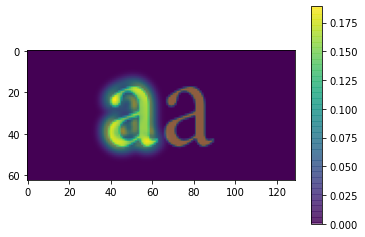

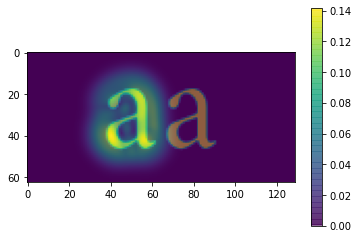


Pair DIFFS:
Pair total cost -30.155582


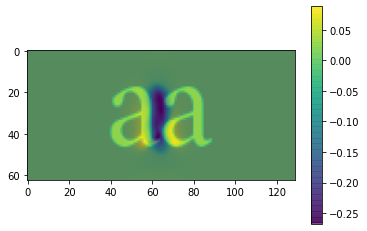

Pair total cost -35.774258


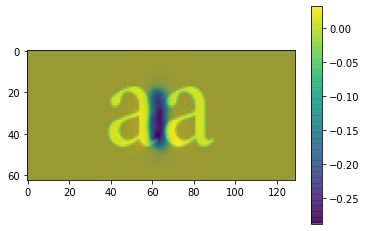

Pair total cost -29.506006


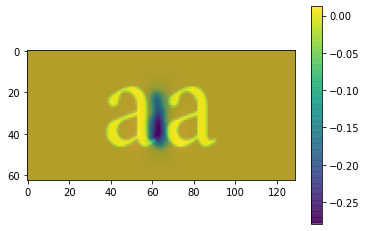

RAW LOSSES for size


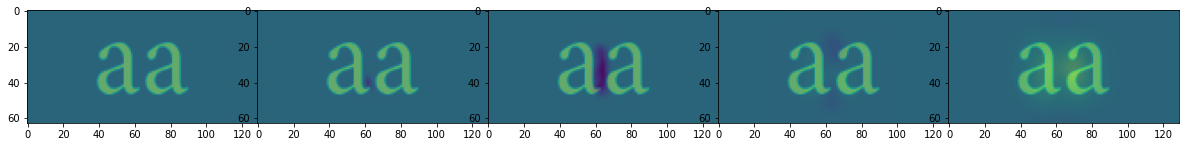

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(2.3841858e-07, shape=(), dtype=float32) total losses: tf.Tensor(1.3831632e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(0.0019437969, shape=(), dtype=float32) total losses: tf.Tensor(0.0902374, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.014888912, shape=(), dtype=float32) total losses: tf.Tensor(0.77363425, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.05678326, shape=(), dtype=float32) total losses: tf.Tensor(20.05671, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.23510659, shape=(), dtype=float32) total losses: tf.Tensor(185.33383, shape=(), dtype=float32)


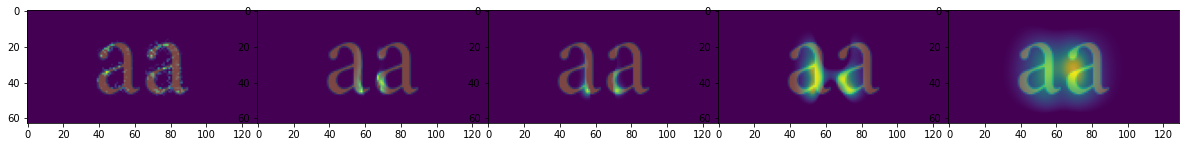

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.007605112, shape=(), dtype=float32) total gain: tf.Tensor(0.058671594, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.2834307, shape=(), dtype=float32) total gain: tf.Tensor(5.933243, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.47028953, shape=(), dtype=float32) total gain: tf.Tensor(70.99406, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.11071582, shape=(), dtype=float32) total gain: tf.Tensor(25.87077, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.03546302, shape=(), dtype=float32) total gain: tf.Tensor(8.265777, shape=(), dtype=float32)


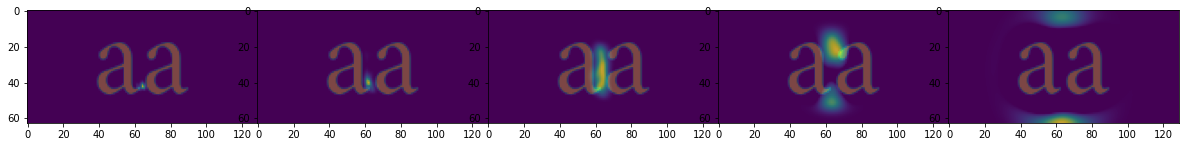

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.55678344, shape=(), dtype=float32) sum tf.Tensor(65.52662, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9284879, shape=(), dtype=float32) sum tf.Tensor(216.338, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9367371, shape=(), dtype=float32) sum tf.Tensor(385.5346, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.7677751, shape=(), dtype=float32) sum tf.Tensor(443.84262, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.6314469, shape=(), dtype=float32) sum tf.Tensor(759.8977, shape=(), dtype=float32)


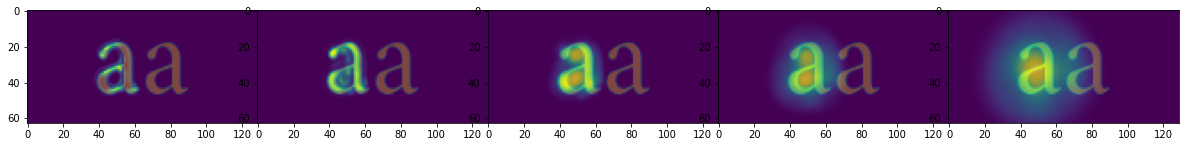

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.55678344, shape=(), dtype=float32) sum tf.Tensor(65.52662, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9284879, shape=(), dtype=float32) sum tf.Tensor(216.338, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9367371, shape=(), dtype=float32) sum tf.Tensor(385.5346, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.7677751, shape=(), dtype=float32) sum tf.Tensor(443.84262, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.6314469, shape=(), dtype=float32) sum tf.Tensor(759.8977, shape=(), dtype=float32)


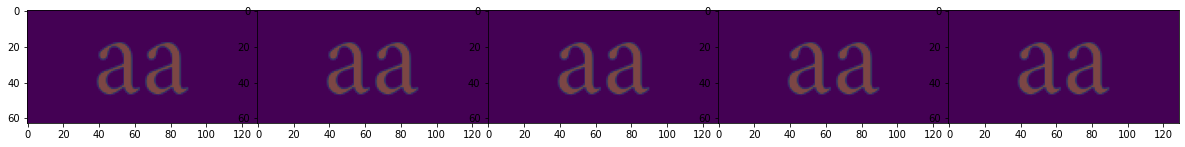

COST of DIFF for size


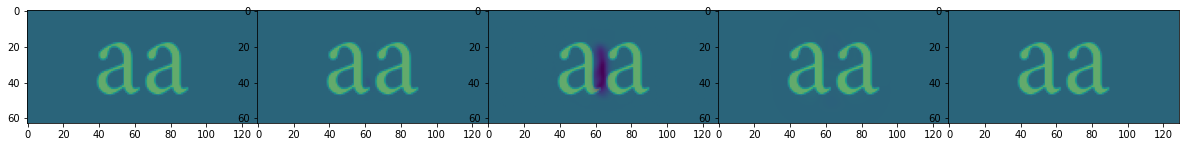

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


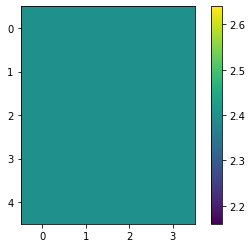

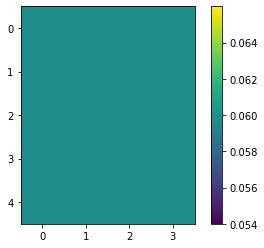

V4 (scales/orientations) exponents [k] and half-points [b]


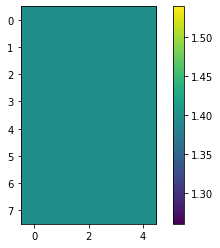

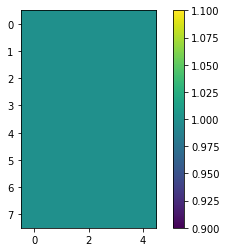

G (scales) exponents [k] and half-points [b]


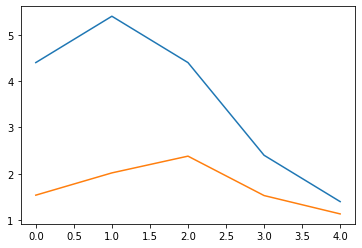

M


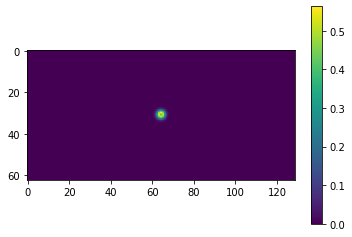

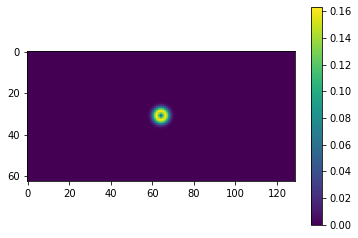

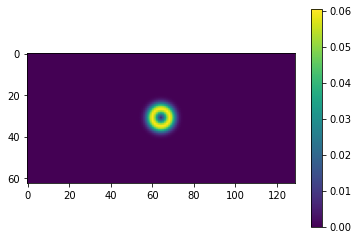

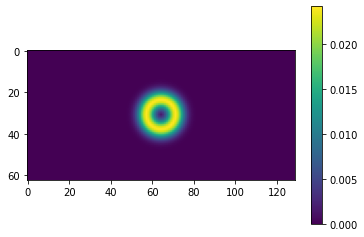

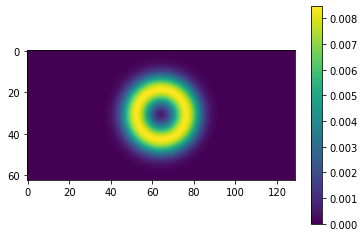

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


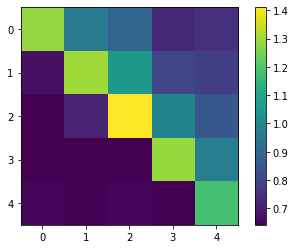

Orientation weights:


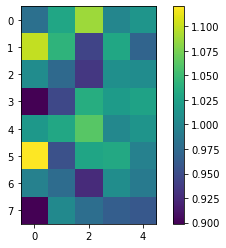

Feedback modulation strength:


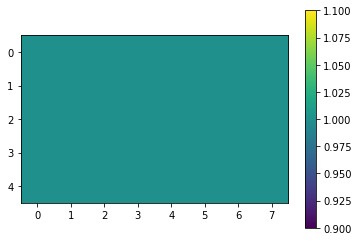

DN Weights (size 2):


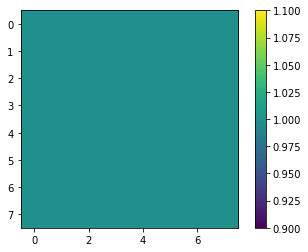

costs
worst violation -5.618675


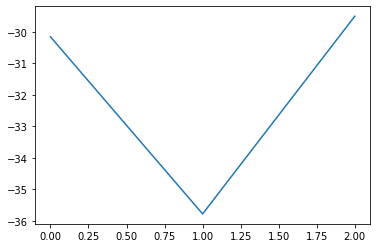

raw_losses


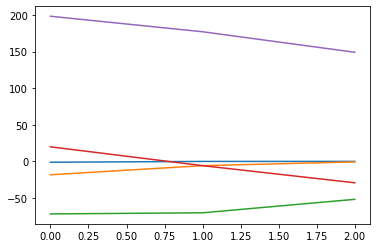

loss penalties (blue for loss, orange for gains


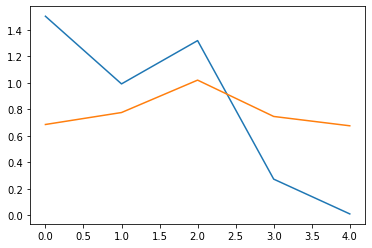

penalty (blue) and reward (orange) exps, by size:


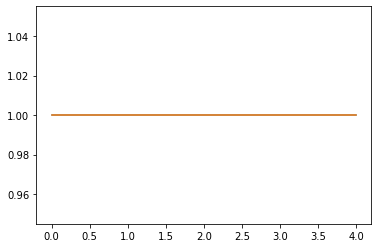

20/20 [==============================] - 22s 1s/step - loss: -1.7308
Epoch 2/1000
20/20 [==============================] - 2s 117ms/step - loss: 2.7083
Epoch 3/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.7630
Epoch 4/1000
20/20 [==============================] - 2s 118ms/step - loss: -0.1538
Epoch 5/1000
20/20 [==============================] - 2s 116ms/step - loss: -1.1224
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: -1.5746['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf_op_la

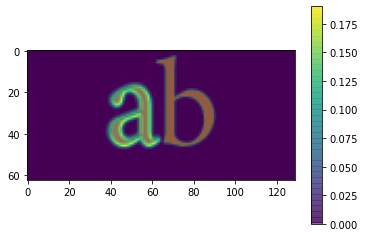

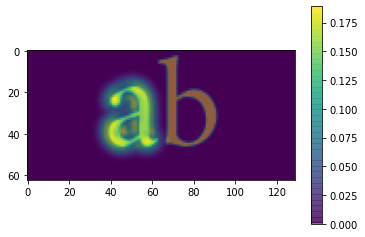

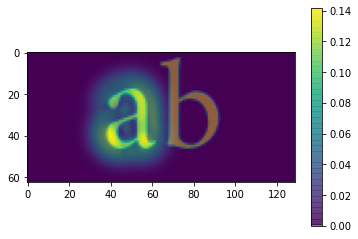


Pair DIFFS:
Pair total cost 35.680874


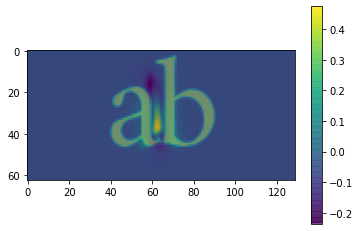

Pair total cost -13.396505


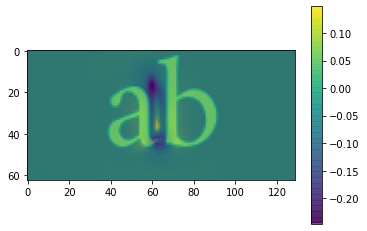

Pair total cost -34.83862


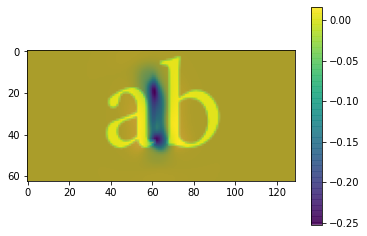

RAW LOSSES for size


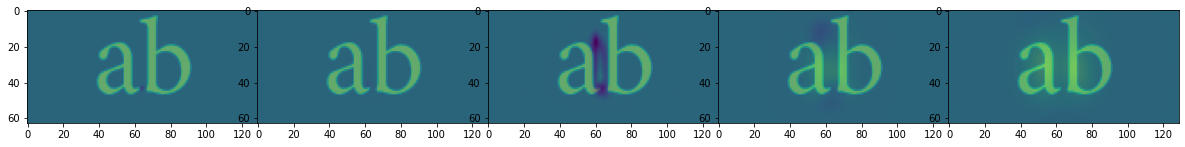

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(3.2782555e-07, shape=(), dtype=float32) total losses: tf.Tensor(2.7721273e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(0.00020238757, shape=(), dtype=float32) total losses: tf.Tensor(0.002081189, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.06516379, shape=(), dtype=float32) total losses: tf.Tensor(1.3786879, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.14234889, shape=(), dtype=float32) total losses: tf.Tensor(61.650772, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.18004042, shape=(), dtype=float32) total losses: tf.Tensor(163.80365, shape=(), dtype=float32)


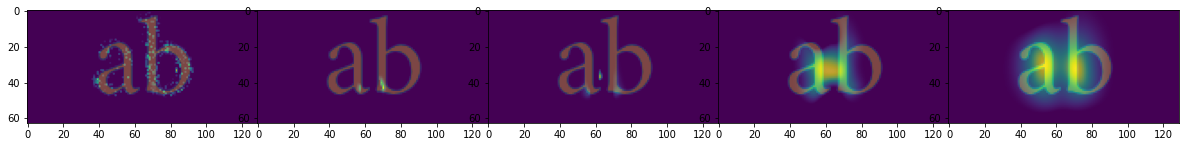

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.23883952, shape=(), dtype=float32) total gain: tf.Tensor(1.2450044, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.078301065, shape=(), dtype=float32) total gain: tf.Tensor(2.1894326, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.4870426, shape=(), dtype=float32) total gain: tf.Tensor(63.92034, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.1258961, shape=(), dtype=float32) total gain: tf.Tensor(19.62696, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.019312724, shape=(), dtype=float32) total gain: tf.Tensor(5.863284, shape=(), dtype=float32)


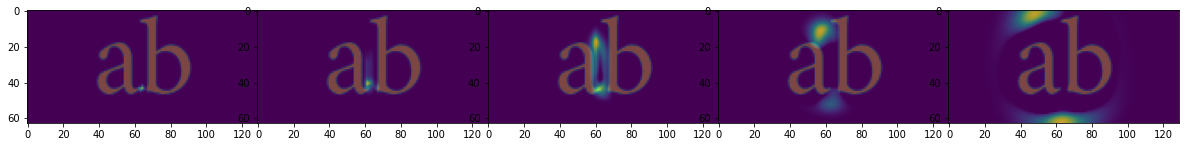

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.9810677, shape=(), dtype=float32) sum tf.Tensor(309.25333, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9064649, shape=(), dtype=float32) sum tf.Tensor(132.1312, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.95916754, shape=(), dtype=float32) sum tf.Tensor(482.21246, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.7319963, shape=(), dtype=float32) sum tf.Tensor(426.89847, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.4926196, shape=(), dtype=float32) sum tf.Tensor(516.4144, shape=(), dtype=float32)


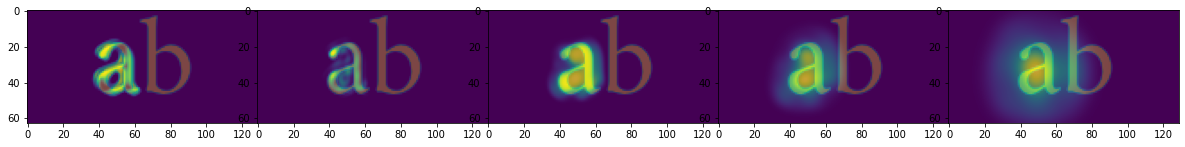

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.9810677, shape=(), dtype=float32) sum tf.Tensor(309.25333, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9064649, shape=(), dtype=float32) sum tf.Tensor(132.1312, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.95916754, shape=(), dtype=float32) sum tf.Tensor(482.21246, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.7319963, shape=(), dtype=float32) sum tf.Tensor(426.89847, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.4926196, shape=(), dtype=float32) sum tf.Tensor(516.4144, shape=(), dtype=float32)


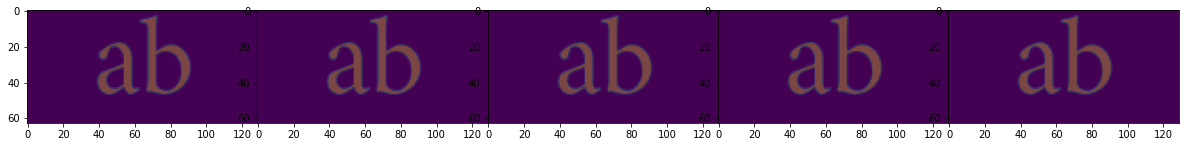

COST of DIFF for size


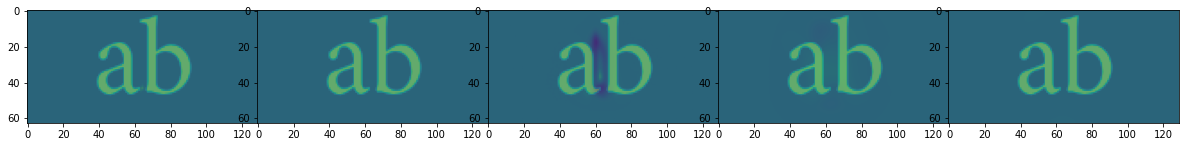

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


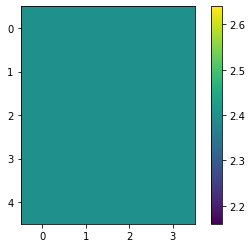

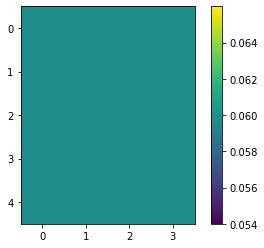

V4 (scales/orientations) exponents [k] and half-points [b]


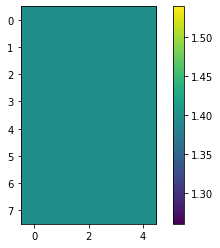

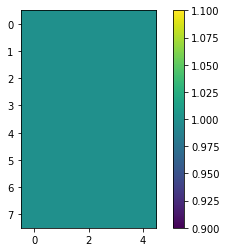

G (scales) exponents [k] and half-points [b]


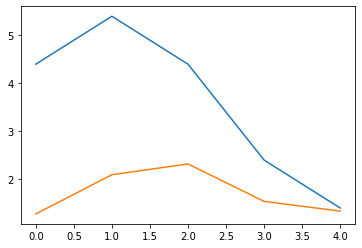

M


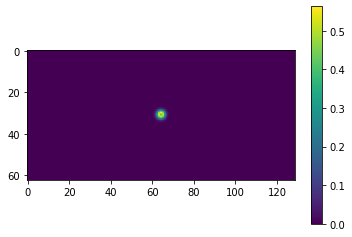

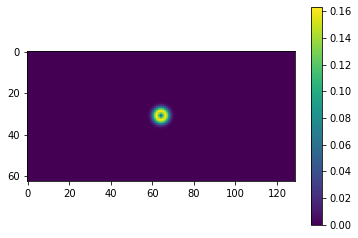

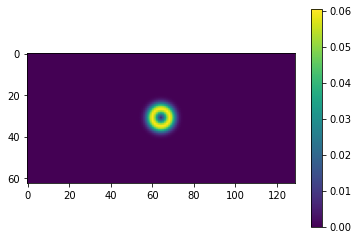

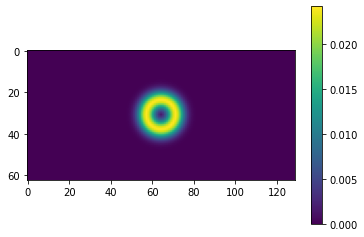

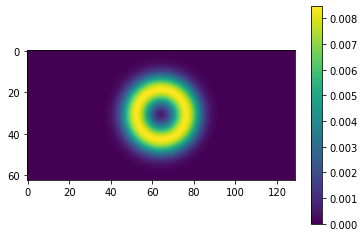

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


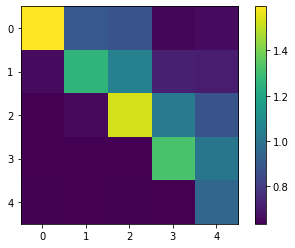

Orientation weights:


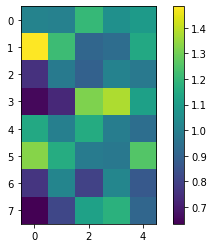

Feedback modulation strength:


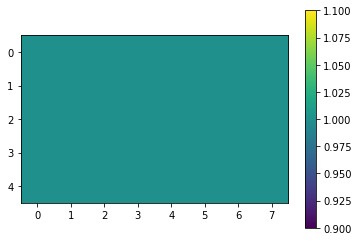

DN Weights (size 2):


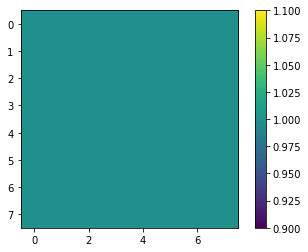

costs
worst violation 21.442114


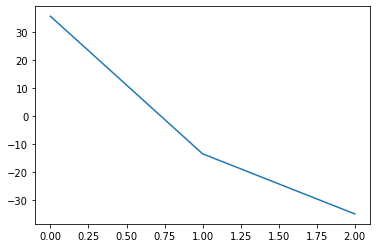

raw_losses


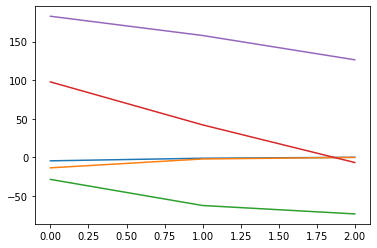

loss penalties (blue for loss, orange for gains


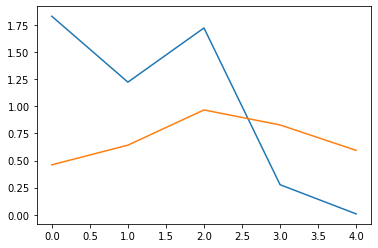

penalty (blue) and reward (orange) exps, by size:


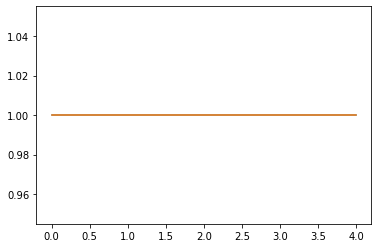

20/20 [==============================] - 21s 1s/step - loss: -1.5746
Epoch 7/1000
20/20 [==============================] - 2s 118ms/step - loss: -0.5446
Epoch 8/1000
20/20 [==============================] - 2s 115ms/step - loss: 0.8461
Epoch 9/1000
20/20 [==============================] - 2s 114ms/step - loss: -0.9582
Epoch 10/1000
20/20 [==============================] - 2s 115ms/step - loss: -2.2809
Epoch 11/1000
20/20 [==============================] - ETA: 0s - loss: -3.1116['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf_op

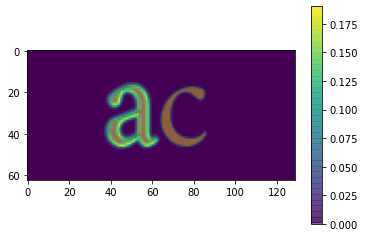

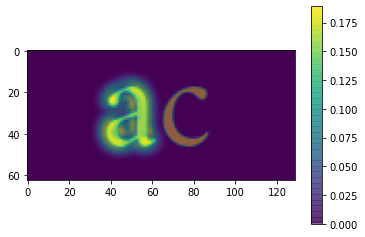

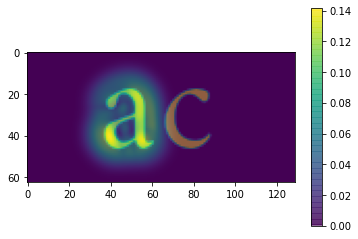


Pair DIFFS:
Pair total cost -5.450042


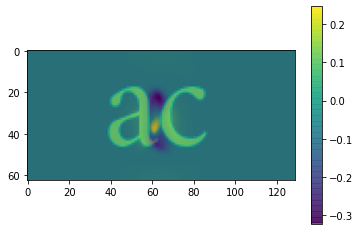

Pair total cost -29.541803


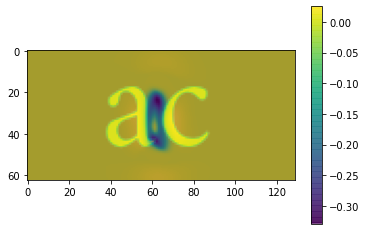

Pair total cost -33.85432


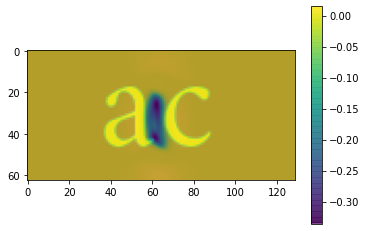

RAW LOSSES for size


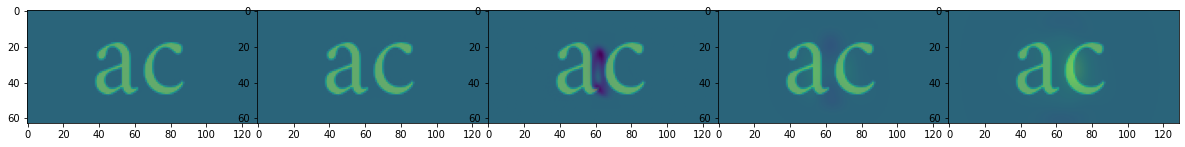

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(2.0861626e-07, shape=(), dtype=float32) total losses: tf.Tensor(1.2931194e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(3.5762787e-07, shape=(), dtype=float32) total losses: tf.Tensor(2.1043707e-05, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.0065083206, shape=(), dtype=float32) total losses: tf.Tensor(0.44653326, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.07278201, shape=(), dtype=float32) total losses: tf.Tensor(21.179544, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.18072027, shape=(), dtype=float32) total losses: tf.Tensor(71.189186, shape=(), dtype=float32)


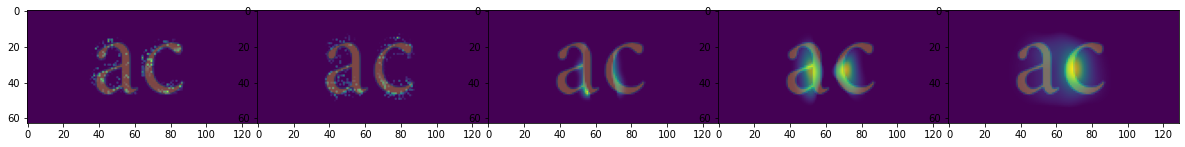

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(2.348423e-05, shape=(), dtype=float32) total gain: tf.Tensor(0.00036885412, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.0011101365, shape=(), dtype=float32) total gain: tf.Tensor(0.024977166, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.4855506, shape=(), dtype=float32) total gain: tf.Tensor(60.36485, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.08177322, shape=(), dtype=float32) total gain: tf.Tensor(19.387072, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.037745714, shape=(), dtype=float32) total gain: tf.Tensor(9.927963, shape=(), dtype=float32)


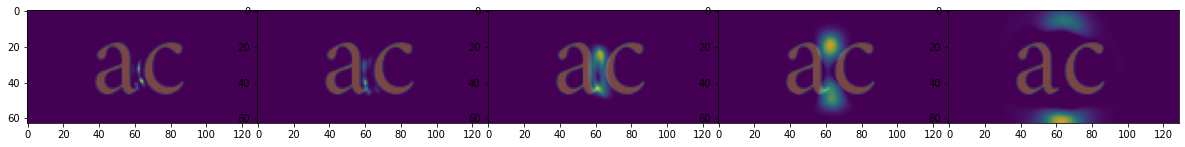

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.8854891, shape=(), dtype=float32) sum tf.Tensor(146.9714, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9672022, shape=(), dtype=float32) sum tf.Tensor(273.8067, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9536968, shape=(), dtype=float32) sum tf.Tensor(470.5735, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.6012877, shape=(), dtype=float32) sum tf.Tensor(295.95294, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.5841497, shape=(), dtype=float32) sum tf.Tensor(666.7064, shape=(), dtype=float32)


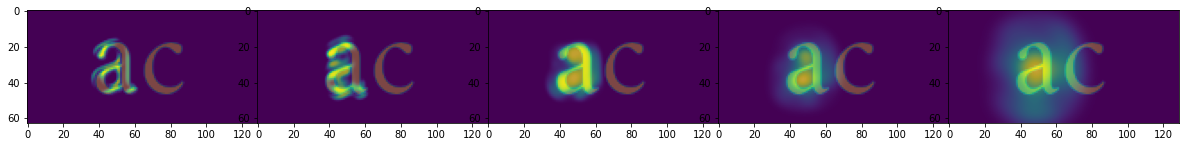

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.8854891, shape=(), dtype=float32) sum tf.Tensor(146.9714, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9672022, shape=(), dtype=float32) sum tf.Tensor(273.8067, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9536968, shape=(), dtype=float32) sum tf.Tensor(470.5735, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.6012877, shape=(), dtype=float32) sum tf.Tensor(295.95294, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.5841497, shape=(), dtype=float32) sum tf.Tensor(666.7064, shape=(), dtype=float32)


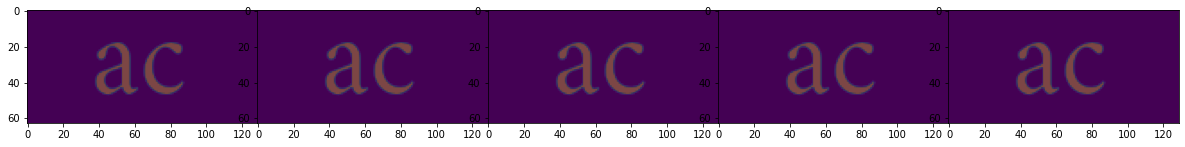

COST of DIFF for size


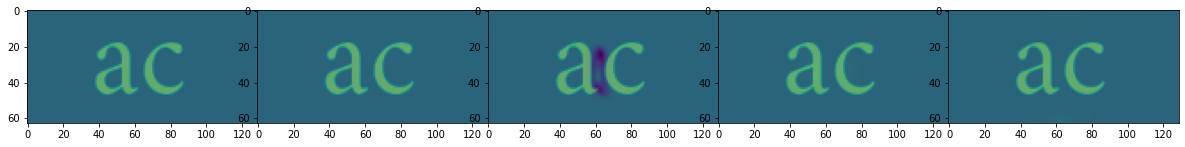

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


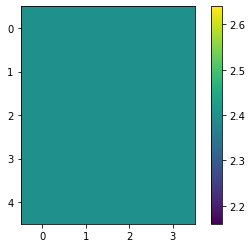

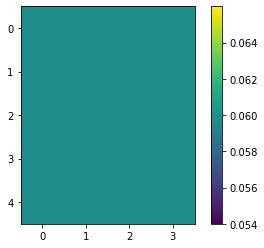

V4 (scales/orientations) exponents [k] and half-points [b]


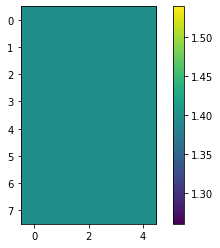

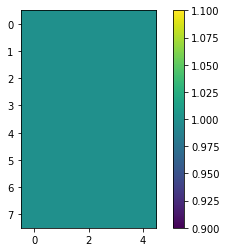

G (scales) exponents [k] and half-points [b]


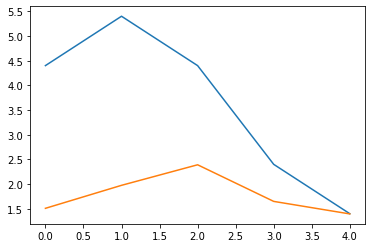

M


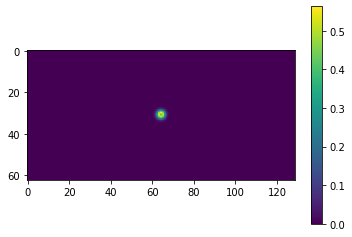

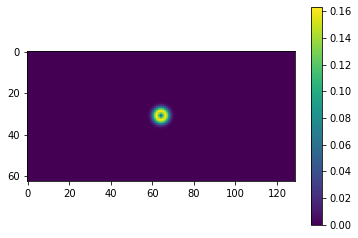

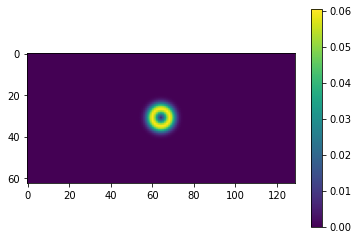

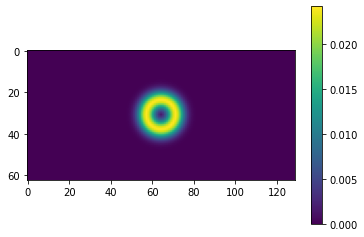

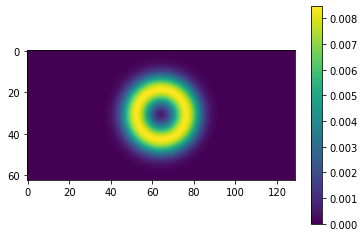

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


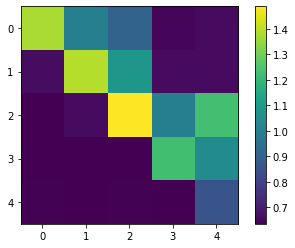

Orientation weights:


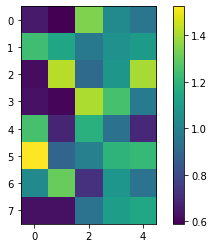

Feedback modulation strength:


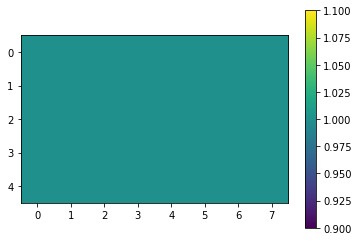

DN Weights (size 2):


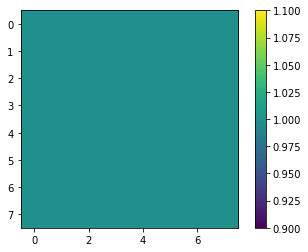

costs
worst violation 4.312517


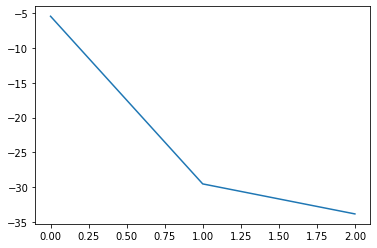

raw_losses


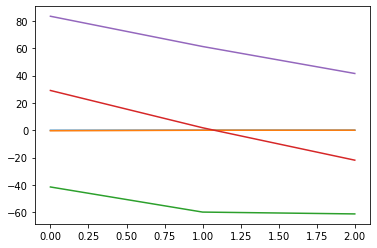

loss penalties (blue for loss, orange for gains


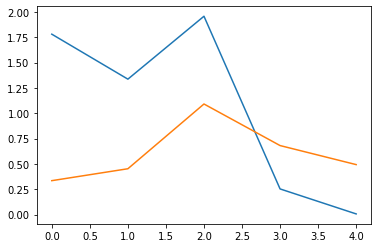

penalty (blue) and reward (orange) exps, by size:


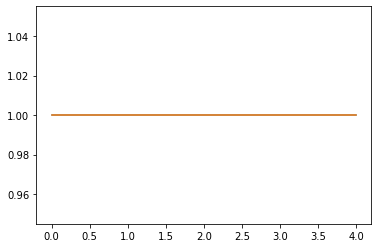

20/20 [==============================] - 22s 1s/step - loss: -3.1116
Epoch 12/1000
20/20 [==============================] - 2s 114ms/step - loss: -2.9063
Epoch 13/1000
20/20 [==============================] - 2s 115ms/step - loss: -6.0588
Epoch 14/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.8083
Epoch 15/1000
20/20 [==============================] - 2s 116ms/step - loss: -1.1959
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: -2.6854['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf

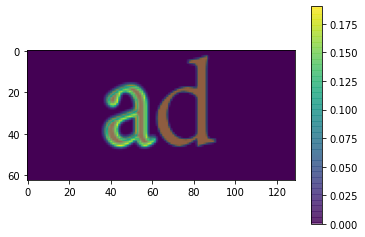

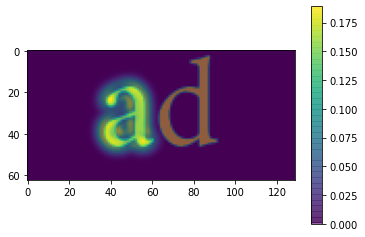

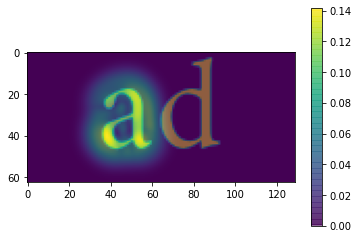


Pair DIFFS:
Pair total cost 15.268494


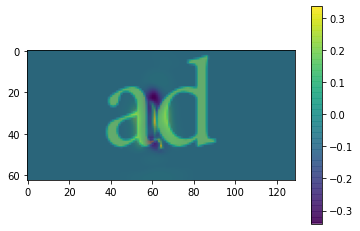

Pair total cost -37.78974


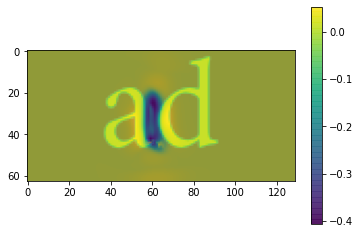

Pair total cost -47.981686


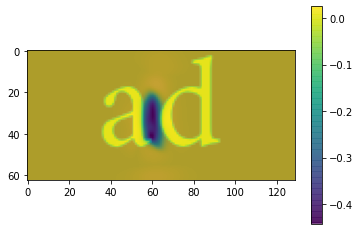

RAW LOSSES for size


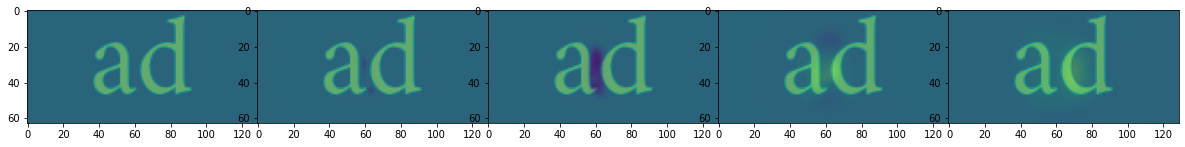

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(2.682209e-07, shape=(), dtype=float32) total losses: tf.Tensor(2.6970803e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(1.0609627e-05, shape=(), dtype=float32) total losses: tf.Tensor(0.0001088233, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.011988431, shape=(), dtype=float32) total losses: tf.Tensor(1.2603226, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.2193622, shape=(), dtype=float32) total losses: tf.Tensor(60.00752, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.24143755, shape=(), dtype=float32) total losses: tf.Tensor(125.77917, shape=(), dtype=float32)


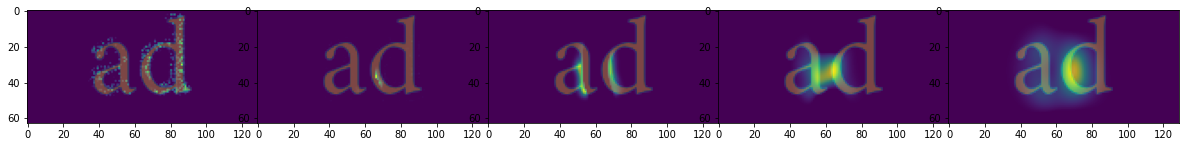

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.00070274994, shape=(), dtype=float32) total gain: tf.Tensor(0.010214515, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.2510079, shape=(), dtype=float32) total gain: tf.Tensor(6.3581643, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.44775987, shape=(), dtype=float32) total gain: tf.Tensor(71.68518, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.12664987, shape=(), dtype=float32) total gain: tf.Tensor(19.62806, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.027434751, shape=(), dtype=float32) total gain: tf.Tensor(4.559284, shape=(), dtype=float32)


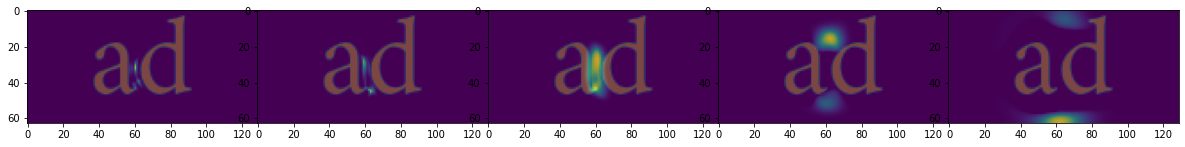

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.9234001, shape=(), dtype=float32) sum tf.Tensor(174.73367, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.99989474, shape=(), dtype=float32) sum tf.Tensor(656.1654, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.898311, shape=(), dtype=float32) sum tf.Tensor(358.07422, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.79919785, shape=(), dtype=float32) sum tf.Tensor(513.37976, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.44844338, shape=(), dtype=float32) sum tf.Tensor(476.4867, shape=(), dtype=float32)


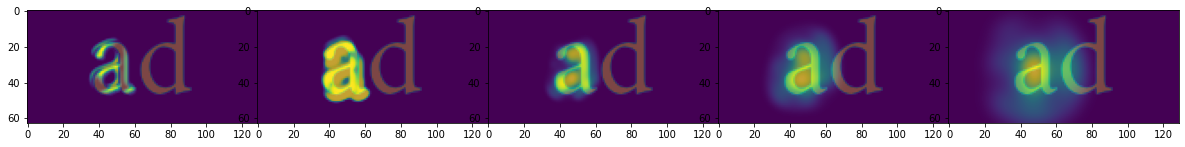

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.9234001, shape=(), dtype=float32) sum tf.Tensor(174.73367, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.99989474, shape=(), dtype=float32) sum tf.Tensor(656.1654, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.898311, shape=(), dtype=float32) sum tf.Tensor(358.07422, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.79919785, shape=(), dtype=float32) sum tf.Tensor(513.37976, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.44844338, shape=(), dtype=float32) sum tf.Tensor(476.4867, shape=(), dtype=float32)


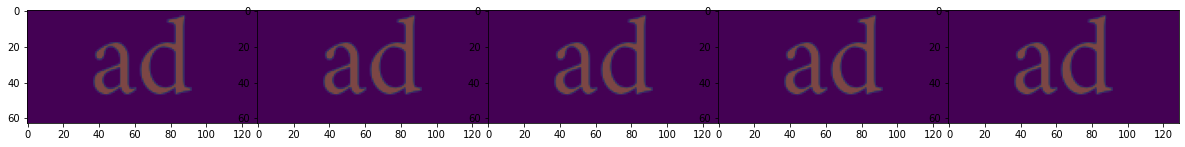

COST of DIFF for size


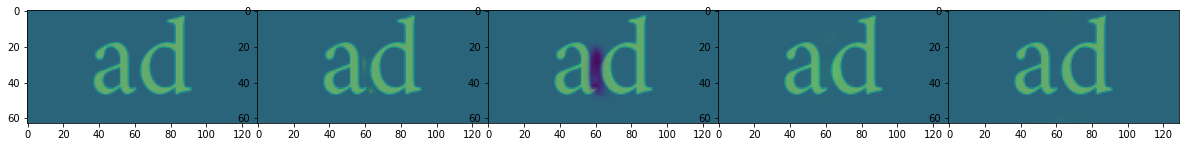

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


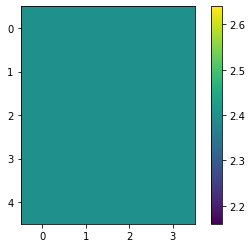

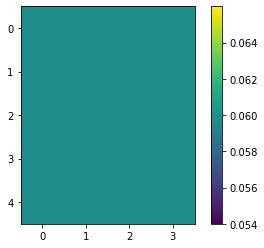

V4 (scales/orientations) exponents [k] and half-points [b]


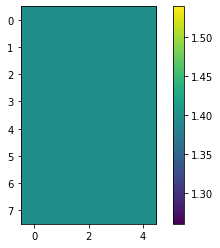

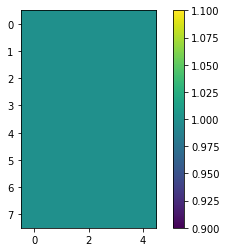

G (scales) exponents [k] and half-points [b]


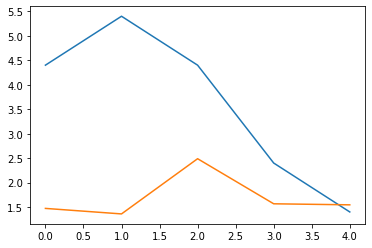

M


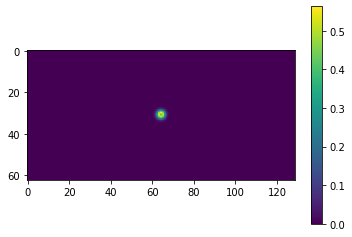

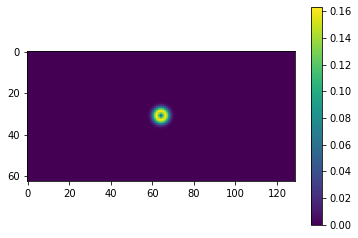

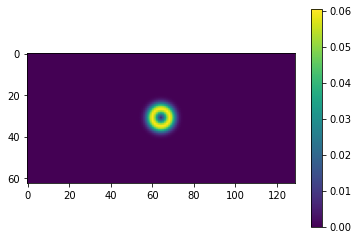

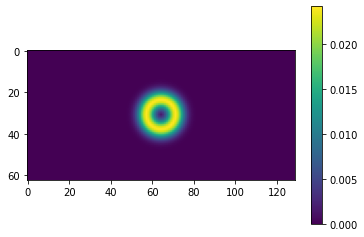

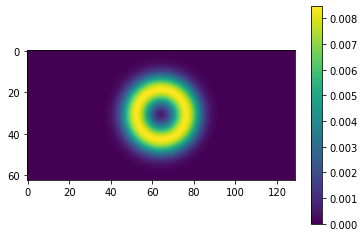

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


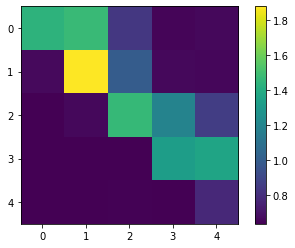

Orientation weights:


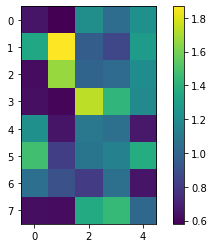

Feedback modulation strength:


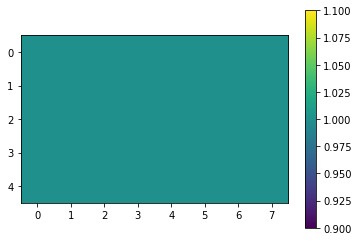

DN Weights (size 2):


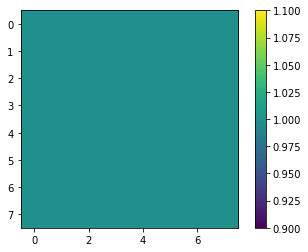

costs
worst violation 10.191944


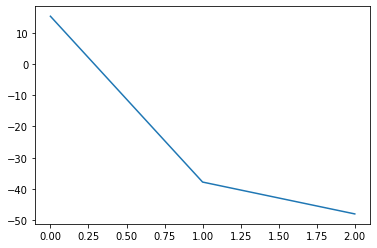

raw_losses


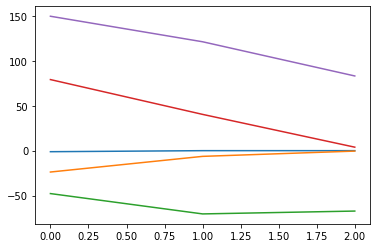

loss penalties (blue for loss, orange for gains


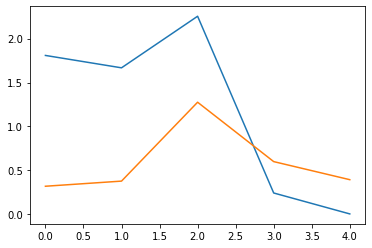

penalty (blue) and reward (orange) exps, by size:


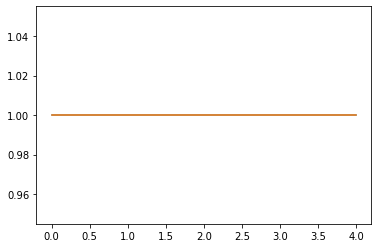

20/20 [==============================] - 21s 1s/step - loss: -2.6854
Epoch 17/1000
20/20 [==============================] - 2s 113ms/step - loss: -3.6000
Epoch 18/1000
20/20 [==============================] - 2s 114ms/step - loss: -4.2128
Epoch 19/1000
20/20 [==============================] - 2s 115ms/step - loss: -0.2527
Epoch 20/1000
20/20 [==============================] - 2s 113ms/step - loss: 1.1169
Epoch 21/1000
20/20 [==============================] - ETA: 0s - loss: -4.7190['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf

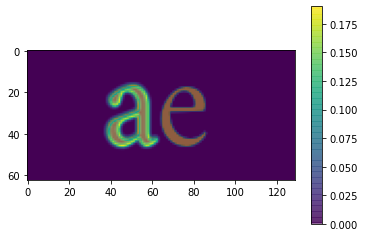

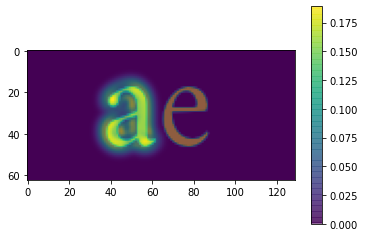

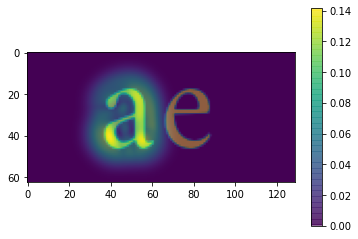


Pair DIFFS:
Pair total cost -32.45047


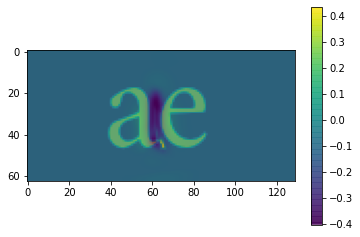

Pair total cost -56.13526


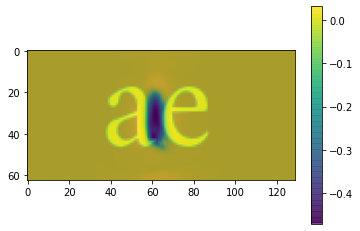

Pair total cost -41.03995


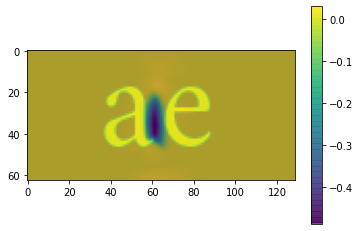

RAW LOSSES for size


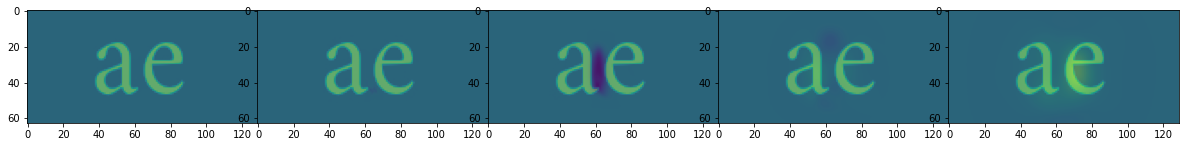

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(2.3841858e-07, shape=(), dtype=float32) total losses: tf.Tensor(1.3431501e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(1.3113022e-06, shape=(), dtype=float32) total losses: tf.Tensor(2.6432226e-05, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.006362438, shape=(), dtype=float32) total losses: tf.Tensor(0.61804783, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.08460057, shape=(), dtype=float32) total losses: tf.Tensor(25.436913, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.27173704, shape=(), dtype=float32) total losses: tf.Tensor(138.44376, shape=(), dtype=float32)


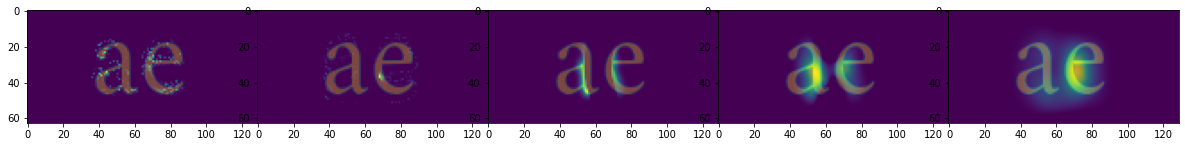

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(6.2012114e-06, shape=(), dtype=float32) total gain: tf.Tensor(0.0001347466, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.09735805, shape=(), dtype=float32) total gain: tf.Tensor(1.1998614, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.46542776, shape=(), dtype=float32) total gain: tf.Tensor(71.47559, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.104269505, shape=(), dtype=float32) total gain: tf.Tensor(16.560097, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.02299346, shape=(), dtype=float32) total gain: tf.Tensor(2.9962244, shape=(), dtype=float32)


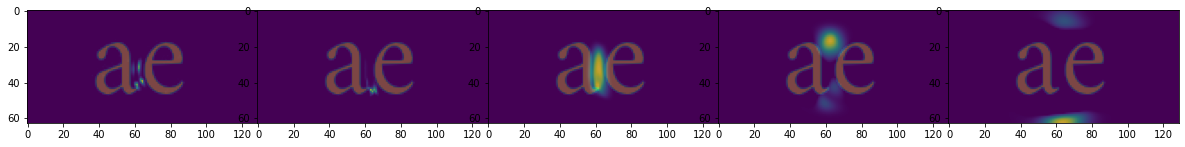

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.8468979, shape=(), dtype=float32) sum tf.Tensor(124.38422, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9999421, shape=(), dtype=float32) sum tf.Tensor(678.48724, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.88281375, shape=(), dtype=float32) sum tf.Tensor(347.17212, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.6925551, shape=(), dtype=float32) sum tf.Tensor(395.66235, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.49661997, shape=(), dtype=float32) sum tf.Tensor(553.063, shape=(), dtype=float32)


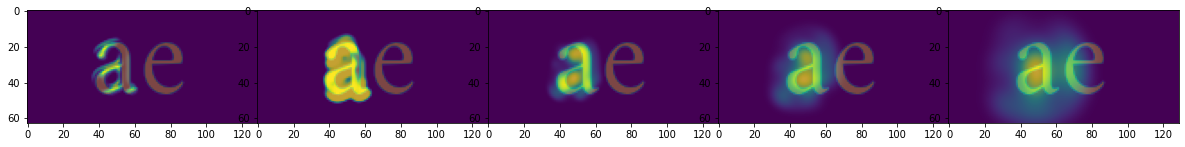

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.8468979, shape=(), dtype=float32) sum tf.Tensor(124.38422, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9999421, shape=(), dtype=float32) sum tf.Tensor(678.48724, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.88281375, shape=(), dtype=float32) sum tf.Tensor(347.17212, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.6925551, shape=(), dtype=float32) sum tf.Tensor(395.66235, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.49661997, shape=(), dtype=float32) sum tf.Tensor(553.063, shape=(), dtype=float32)


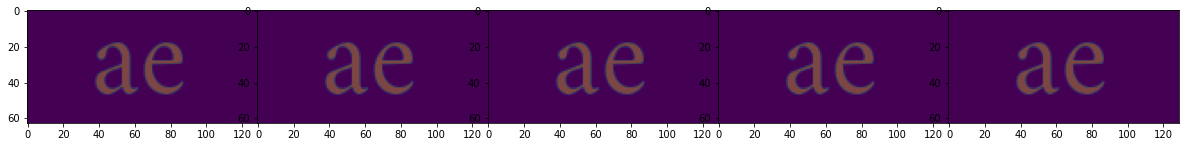

COST of DIFF for size


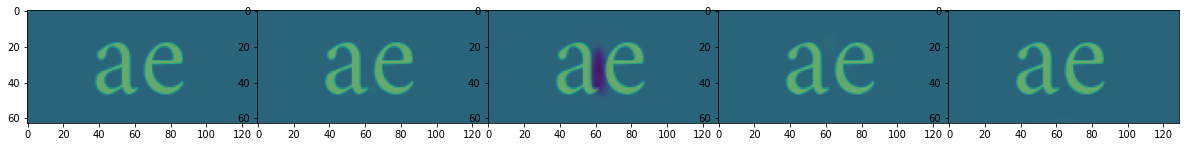

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


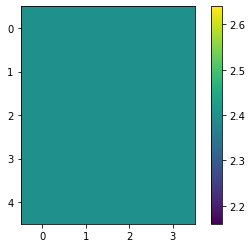

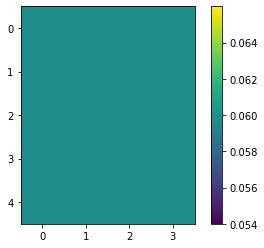

V4 (scales/orientations) exponents [k] and half-points [b]


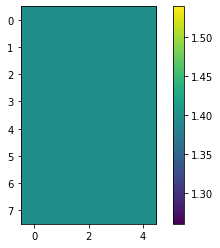

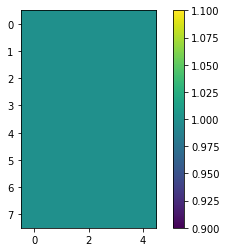

G (scales) exponents [k] and half-points [b]


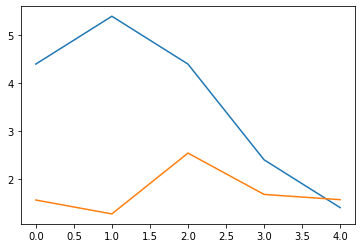

M


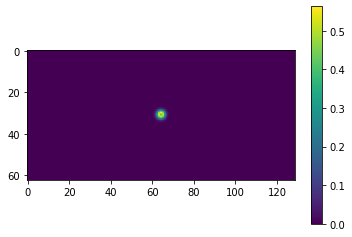

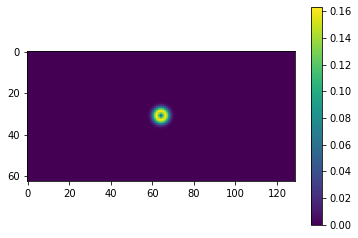

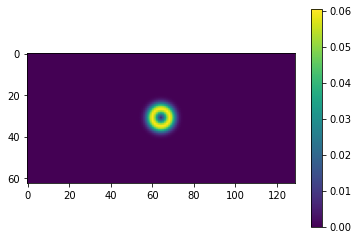

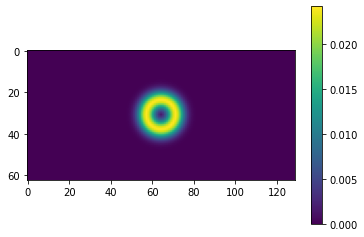

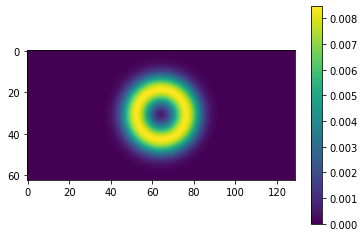

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


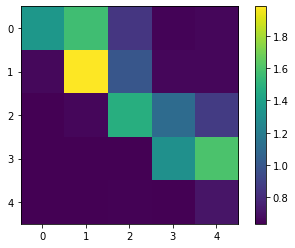

Orientation weights:


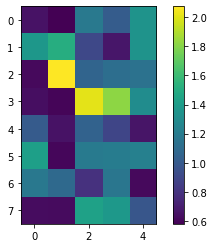

Feedback modulation strength:


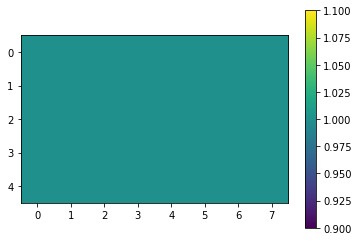

DN Weights (size 2):


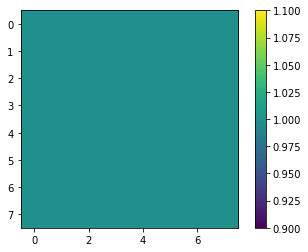

costs
worst violation -15.09531


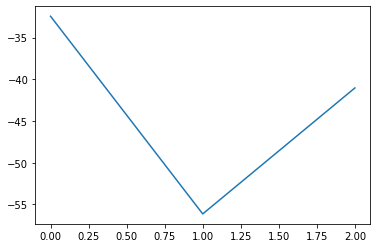

raw_losses


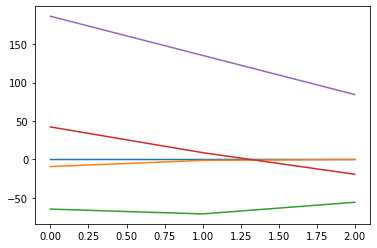

loss penalties (blue for loss, orange for gains


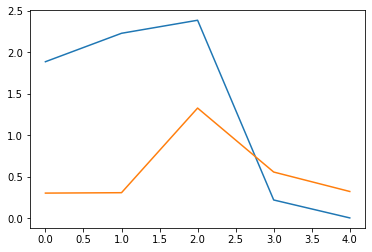

penalty (blue) and reward (orange) exps, by size:


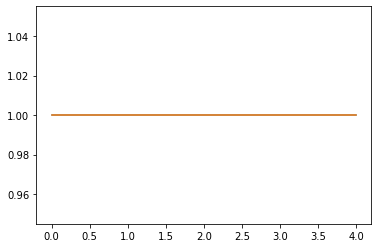

20/20 [==============================] - 22s 1s/step - loss: -4.7190
Epoch 22/1000
20/20 [==============================] - 2s 114ms/step - loss: -8.2952
Epoch 23/1000
20/20 [==============================] - 2s 114ms/step - loss: 2.9656
Epoch 24/1000
20/20 [==============================] - 2s 115ms/step - loss: 2.0497
Epoch 25/1000
20/20 [==============================] - 2s 114ms/step - loss: -7.0630
Epoch 26/1000
20/20 [==============================] - ETA: 0s - loss: -7.1353['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf_

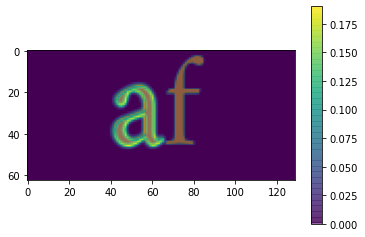

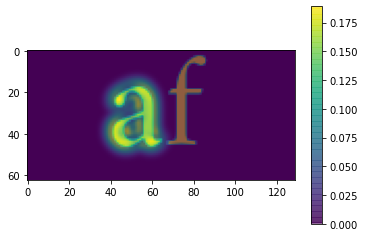

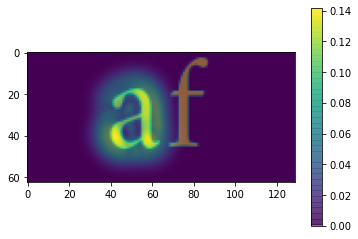


Pair DIFFS:
Pair total cost -22.276503


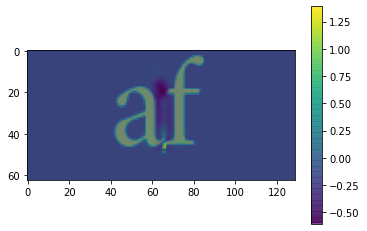

Pair total cost -53.81929


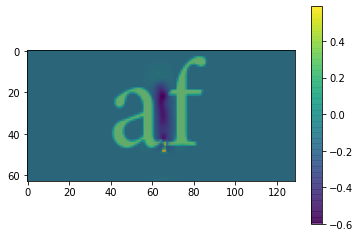

Pair total cost -39.55916


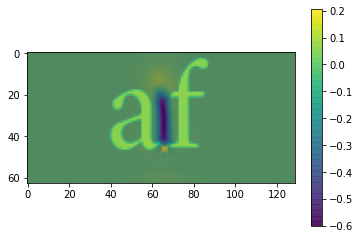

RAW LOSSES for size


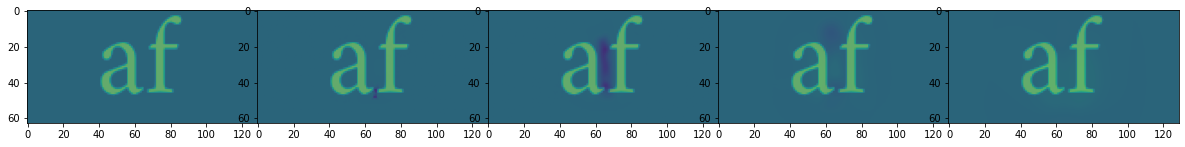

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(1.8522143e-05, shape=(), dtype=float32) total losses: tf.Tensor(5.8169597e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(3.6001205e-05, shape=(), dtype=float32) total losses: tf.Tensor(0.00025154394, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.025666684, shape=(), dtype=float32) total losses: tf.Tensor(1.0167466, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.05370298, shape=(), dtype=float32) total losses: tf.Tensor(20.353214, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.08475697, shape=(), dtype=float32) total losses: tf.Tensor(61.17409, shape=(), dtype=float32)


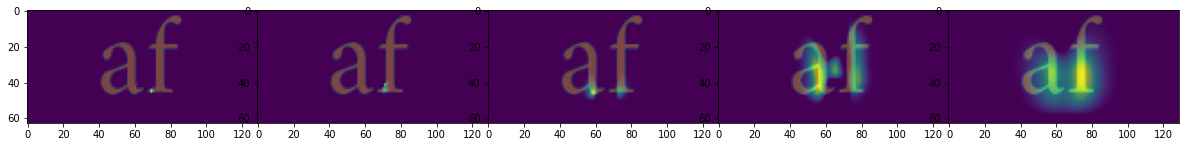

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.03371761, shape=(), dtype=float32) total gain: tf.Tensor(0.27045846, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.53073704, shape=(), dtype=float32) total gain: tf.Tensor(5.1282787, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.48829618, shape=(), dtype=float32) total gain: tf.Tensor(66.93172, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.13130686, shape=(), dtype=float32) total gain: tf.Tensor(25.259478, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.012693748, shape=(), dtype=float32) total gain: tf.Tensor(2.9197679, shape=(), dtype=float32)


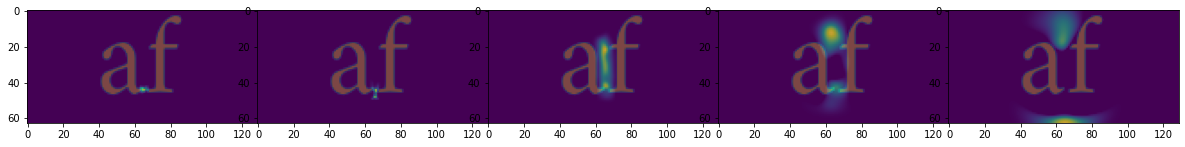

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.7255013, shape=(), dtype=float32) sum tf.Tensor(74.93038, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9996121, shape=(), dtype=float32) sum tf.Tensor(566.2799, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9611716, shape=(), dtype=float32) sum tf.Tensor(510.10736, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.7017518, shape=(), dtype=float32) sum tf.Tensor(406.0062, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.39323547, shape=(), dtype=float32) sum tf.Tensor(383.34863, shape=(), dtype=float32)


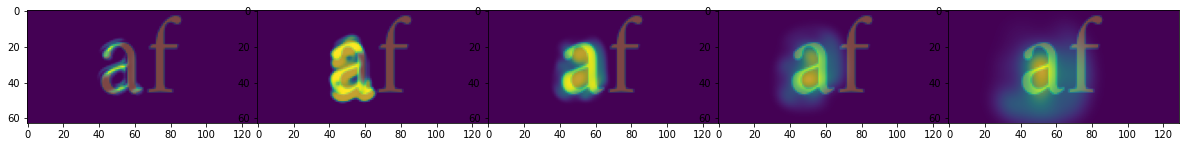

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.7255013, shape=(), dtype=float32) sum tf.Tensor(74.93038, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9996121, shape=(), dtype=float32) sum tf.Tensor(566.2799, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9611716, shape=(), dtype=float32) sum tf.Tensor(510.10736, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.7017518, shape=(), dtype=float32) sum tf.Tensor(406.0062, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.39323547, shape=(), dtype=float32) sum tf.Tensor(383.34863, shape=(), dtype=float32)


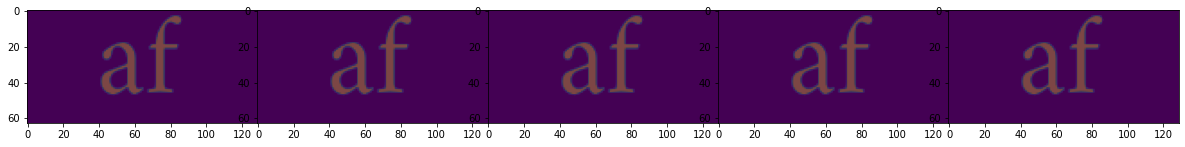

COST of DIFF for size


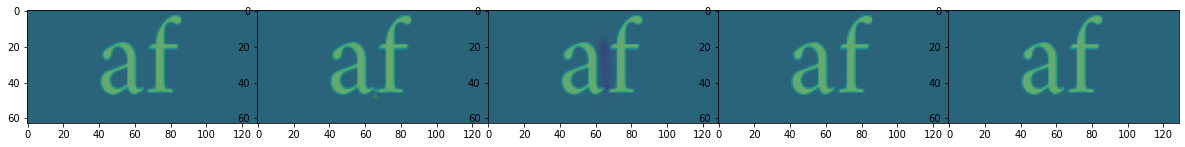

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


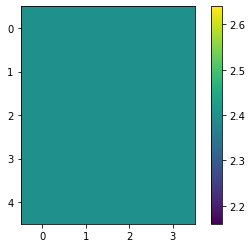

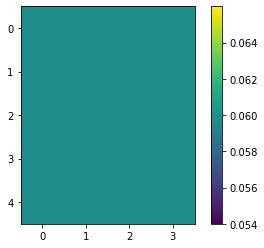

V4 (scales/orientations) exponents [k] and half-points [b]


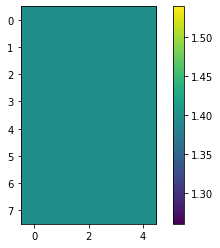

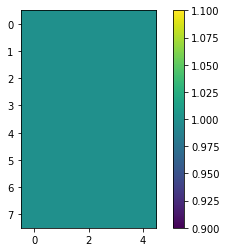

G (scales) exponents [k] and half-points [b]


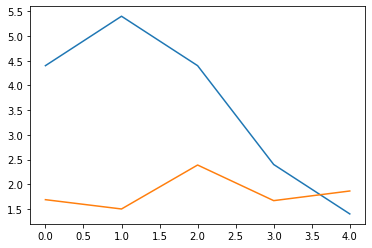

M


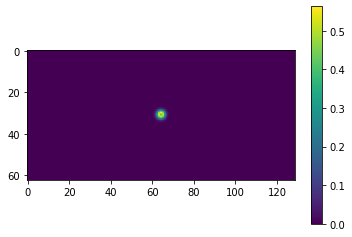

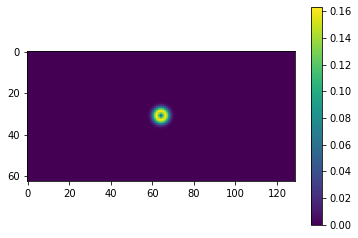

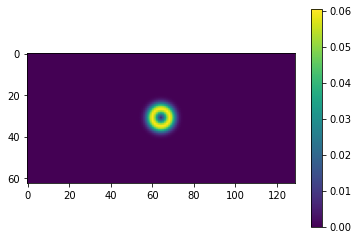

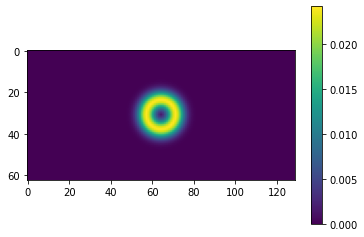

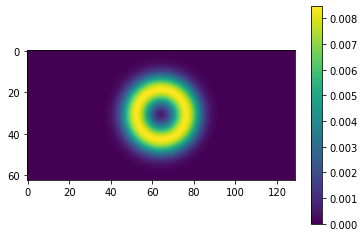

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


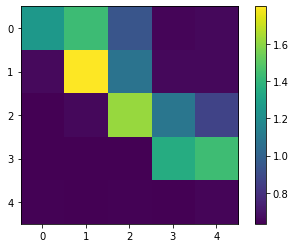

Orientation weights:


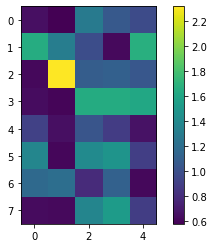

Feedback modulation strength:


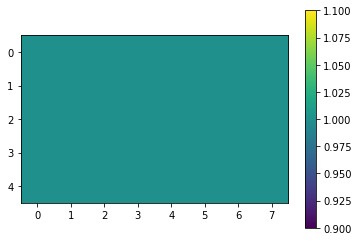

DN Weights (size 2):


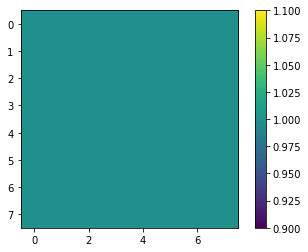

costs
worst violation -14.260132


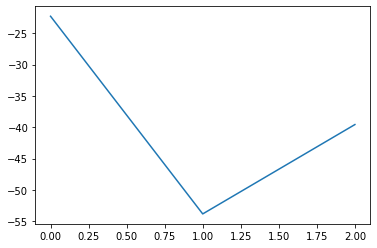

raw_losses


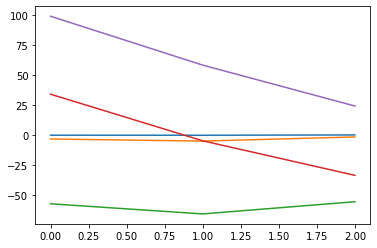

loss penalties (blue for loss, orange for gains


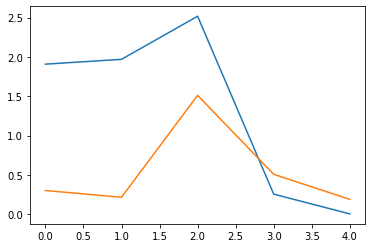

penalty (blue) and reward (orange) exps, by size:


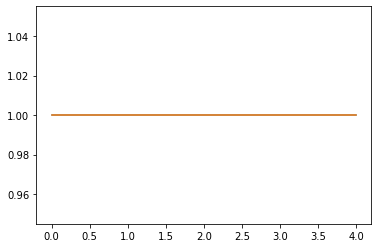

20/20 [==============================] - 21s 1s/step - loss: -7.1353
Epoch 27/1000
20/20 [==============================] - 2s 115ms/step - loss: -5.0470
Epoch 28/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.4740
Epoch 29/1000
20/20 [==============================] - 2s 114ms/step - loss: 5.5483
Epoch 30/1000
20/20 [==============================] - 2s 114ms/step - loss: 0.1630
Epoch 31/1000
20/20 [==============================] - ETA: 0s - loss: -9.8591 ['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf_

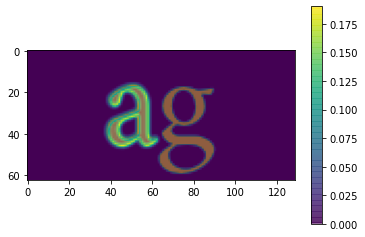

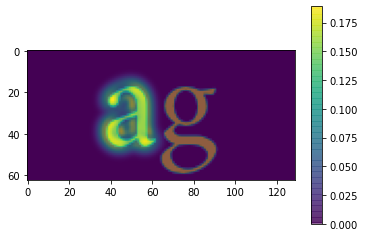

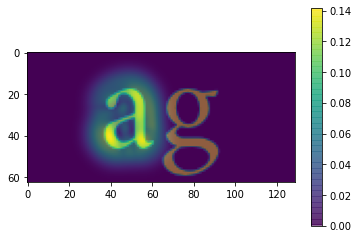


Pair DIFFS:
Pair total cost 54.382935


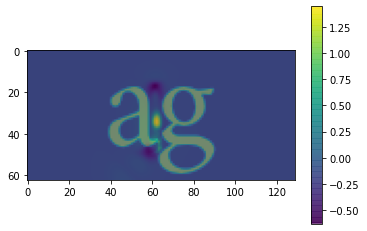

Pair total cost -33.79311


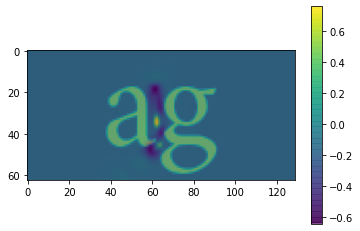

Pair total cost -68.713905


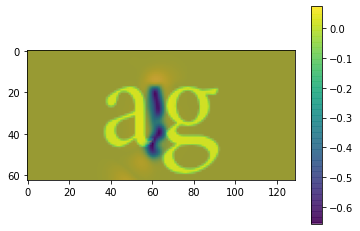

RAW LOSSES for size


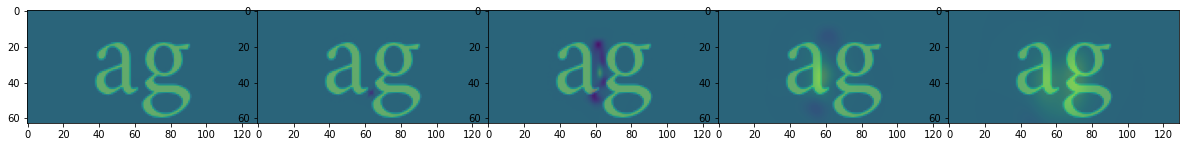

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(2.3841858e-07, shape=(), dtype=float32) total losses: tf.Tensor(1.8008512e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(2.1457672e-06, shape=(), dtype=float32) total losses: tf.Tensor(4.6891913e-05, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.26624042, shape=(), dtype=float32) total losses: tf.Tensor(2.843682, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.27200705, shape=(), dtype=float32) total losses: tf.Tensor(61.524246, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.25280458, shape=(), dtype=float32) total losses: tf.Tensor(199.81648, shape=(), dtype=float32)


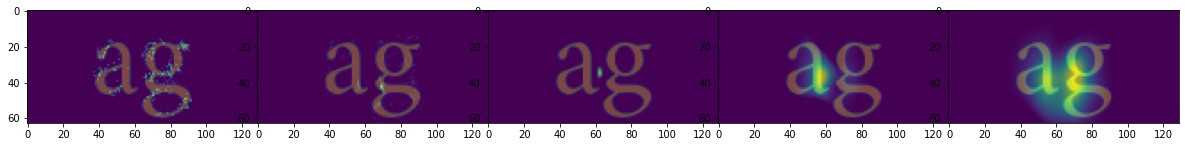

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.004212821, shape=(), dtype=float32) total gain: tf.Tensor(0.030368062, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.32134417, shape=(), dtype=float32) total gain: tf.Tensor(3.4304612, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.4885881, shape=(), dtype=float32) total gain: tf.Tensor(57.814568, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.1159718, shape=(), dtype=float32) total gain: tf.Tensor(22.445538, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.03459461, shape=(), dtype=float32) total gain: tf.Tensor(2.0896087, shape=(), dtype=float32)


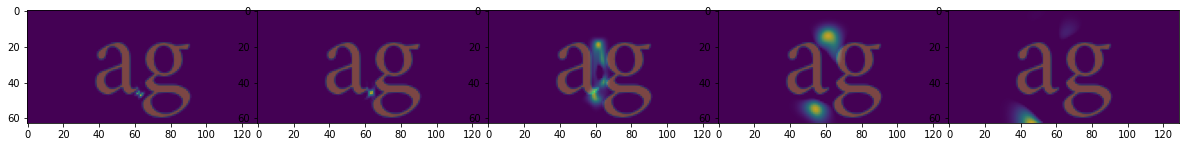

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.87608856, shape=(), dtype=float32) sum tf.Tensor(118.252426, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9987194, shape=(), dtype=float32) sum tf.Tensor(532.9496, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9845961, shape=(), dtype=float32) sum tf.Tensor(640.14954, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.75645846, shape=(), dtype=float32) sum tf.Tensor(501.00784, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.59057605, shape=(), dtype=float32) sum tf.Tensor(706.2763, shape=(), dtype=float32)


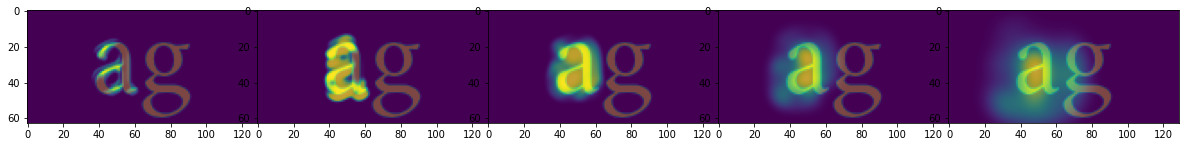

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.87608856, shape=(), dtype=float32) sum tf.Tensor(118.252426, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9987194, shape=(), dtype=float32) sum tf.Tensor(532.9496, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9845961, shape=(), dtype=float32) sum tf.Tensor(640.14954, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.75645846, shape=(), dtype=float32) sum tf.Tensor(501.00784, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.59057605, shape=(), dtype=float32) sum tf.Tensor(706.2763, shape=(), dtype=float32)


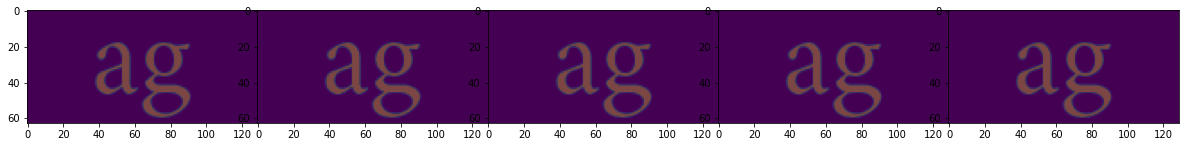

COST of DIFF for size


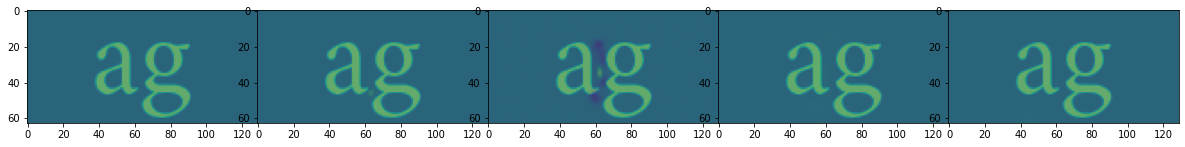

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


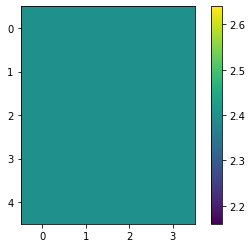

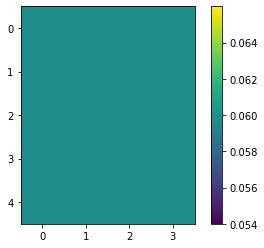

V4 (scales/orientations) exponents [k] and half-points [b]


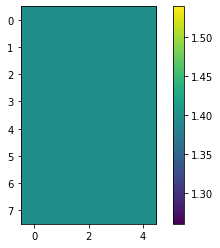

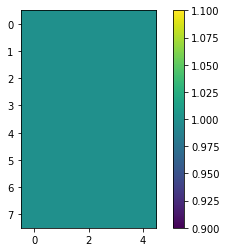

G (scales) exponents [k] and half-points [b]


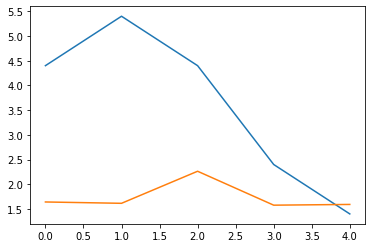

M


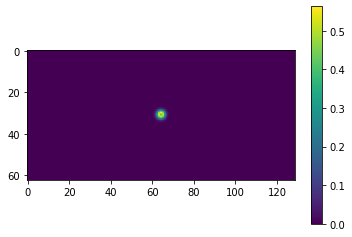

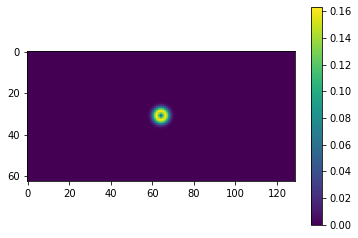

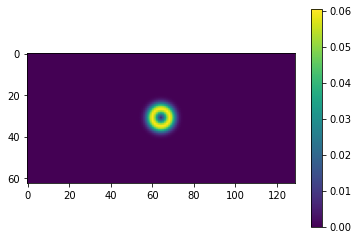

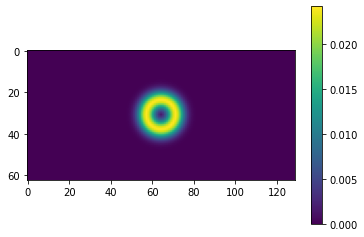

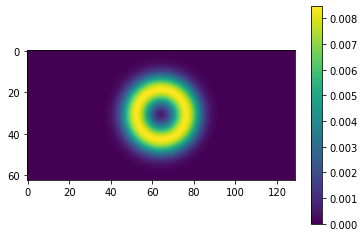

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


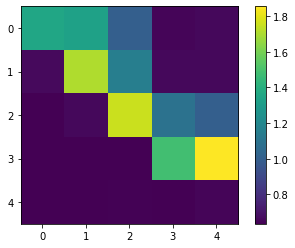

Orientation weights:


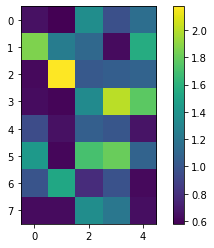

Feedback modulation strength:


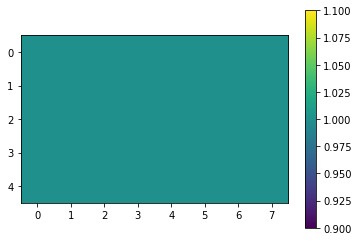

DN Weights (size 2):


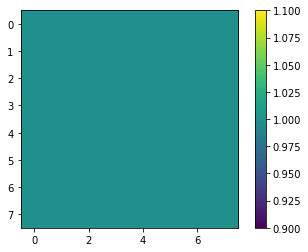

costs
worst violation 34.920795


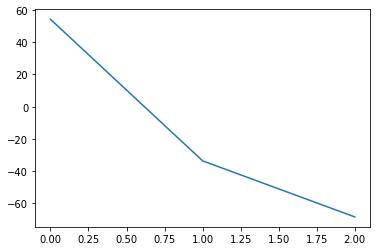

raw_losses


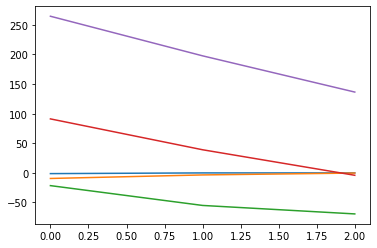

loss penalties (blue for loss, orange for gains


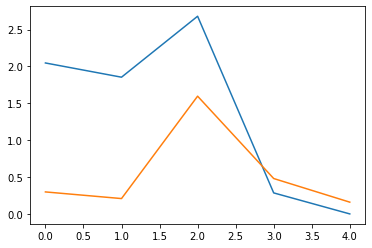

penalty (blue) and reward (orange) exps, by size:


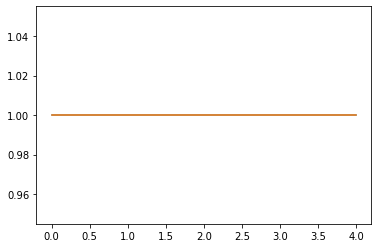

20/20 [==============================] - 22s 1s/step - loss: -9.8591
Epoch 32/1000
20/20 [==============================] - 2s 116ms/step - loss: -3.3678
Epoch 33/1000
20/20 [==============================] - 2s 114ms/step - loss: 3.4010
Epoch 34/1000
20/20 [==============================] - 2s 115ms/step - loss: -1.2864
Epoch 35/1000
20/20 [==============================] - 2s 114ms/step - loss: 1.0026
Epoch 36/1000
20/20 [==============================] - ETA: 0s - loss: -2.0161['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf_

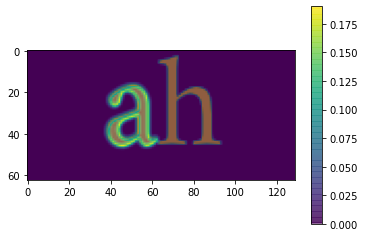

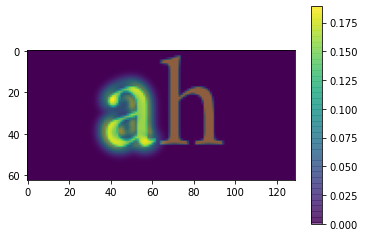

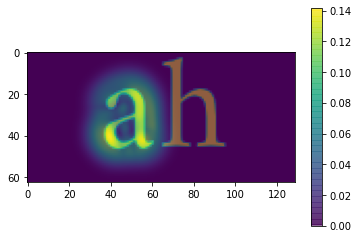


Pair DIFFS:
Pair total cost 3.544467


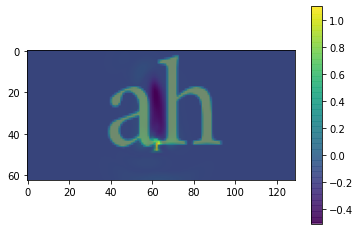

Pair total cost -28.941326


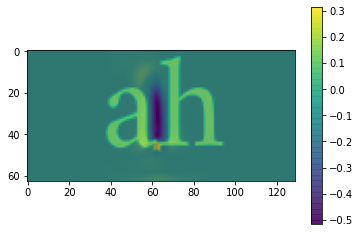

Pair total cost -18.929914


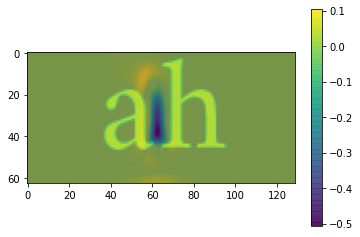

RAW LOSSES for size


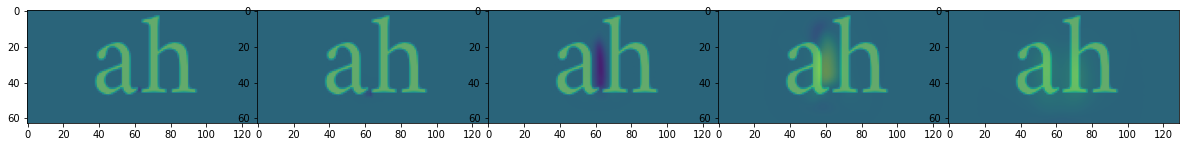

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(6.979704e-05, shape=(), dtype=float32) total losses: tf.Tensor(0.00019652346, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(0.0011112094, shape=(), dtype=float32) total losses: tf.Tensor(0.0061081154, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.031306207, shape=(), dtype=float32) total losses: tf.Tensor(1.7201259, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.3829844, shape=(), dtype=float32) total losses: tf.Tensor(107.4075, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.17191076, shape=(), dtype=float32) total losses: tf.Tensor(132.23215, shape=(), dtype=float32)


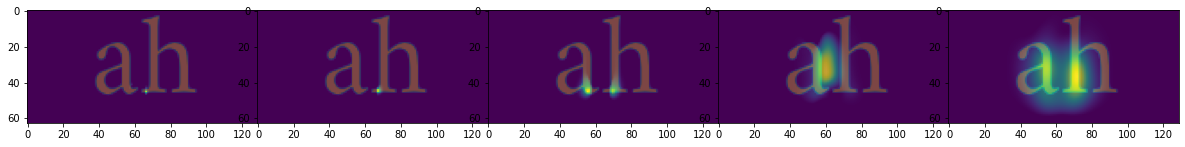

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.30393267, shape=(), dtype=float32) total gain: tf.Tensor(1.8174863, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.23809555, shape=(), dtype=float32) total gain: tf.Tensor(2.7504618, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.48750743, shape=(), dtype=float32) total gain: tf.Tensor(69.64875, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.14086598, shape=(), dtype=float32) total gain: tf.Tensor(13.934885, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.028687075, shape=(), dtype=float32) total gain: tf.Tensor(2.5850892, shape=(), dtype=float32)


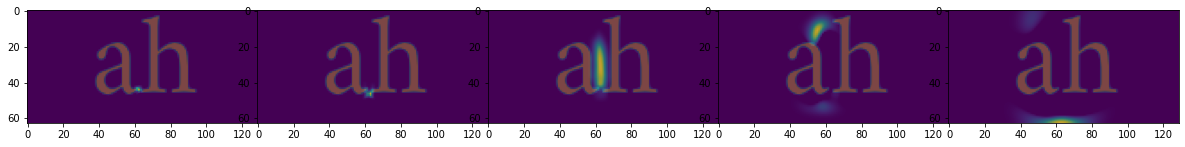

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.9477317, shape=(), dtype=float32) sum tf.Tensor(176.41376, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.97265667, shape=(), dtype=float32) sum tf.Tensor(261.37094, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.89927644, shape=(), dtype=float32) sum tf.Tensor(373.20038, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.8597206, shape=(), dtype=float32) sum tf.Tensor(701.0958, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.4973752, shape=(), dtype=float32) sum tf.Tensor(536.9615, shape=(), dtype=float32)


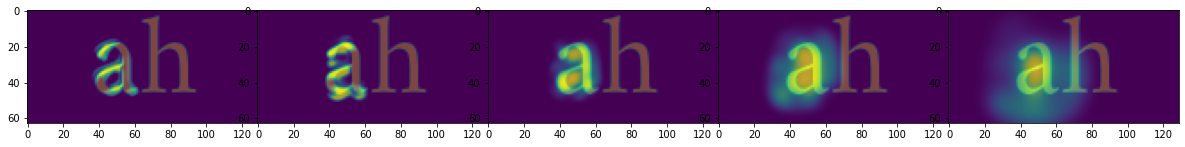

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.9477317, shape=(), dtype=float32) sum tf.Tensor(176.41376, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.97265667, shape=(), dtype=float32) sum tf.Tensor(261.37094, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.89927644, shape=(), dtype=float32) sum tf.Tensor(373.20038, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.8597206, shape=(), dtype=float32) sum tf.Tensor(701.0958, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.4973752, shape=(), dtype=float32) sum tf.Tensor(536.9615, shape=(), dtype=float32)


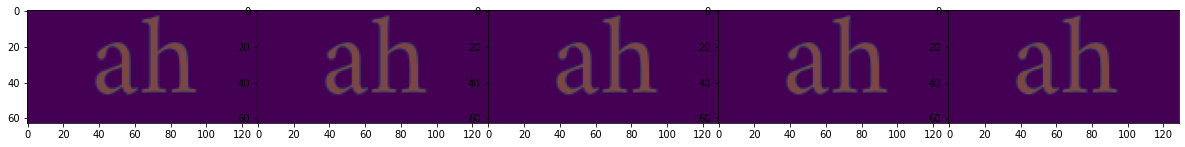

COST of DIFF for size


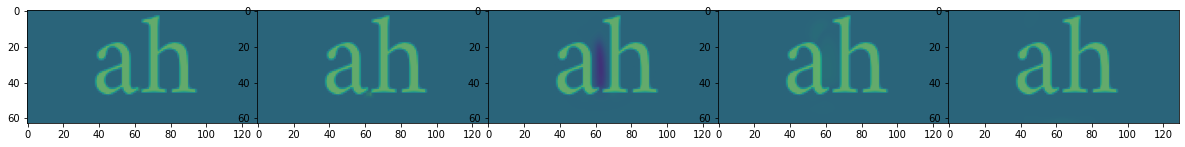

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


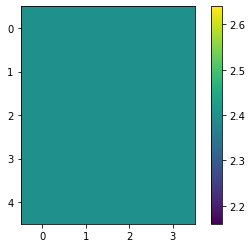

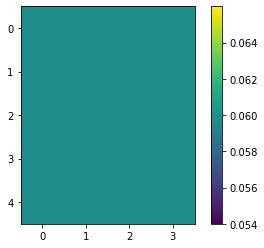

V4 (scales/orientations) exponents [k] and half-points [b]


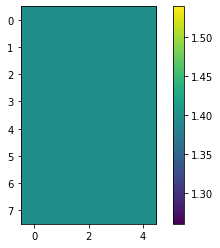

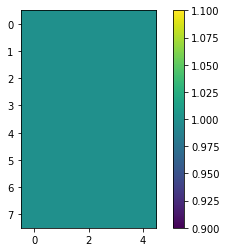

G (scales) exponents [k] and half-points [b]


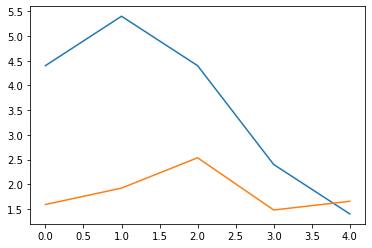

M


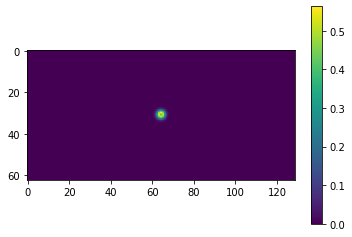

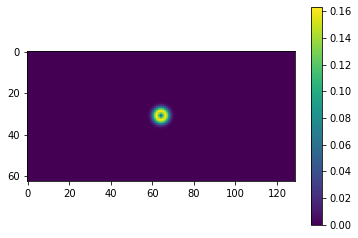

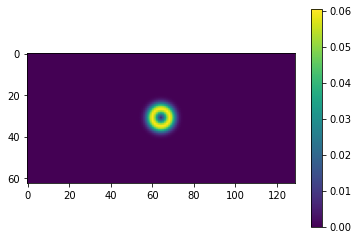

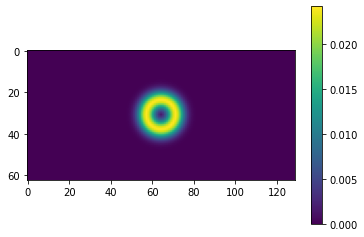

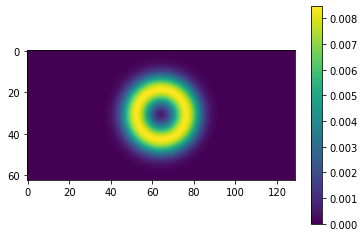

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


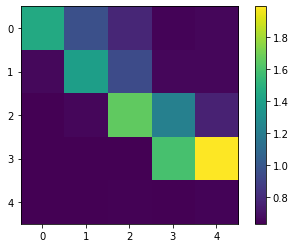

Orientation weights:


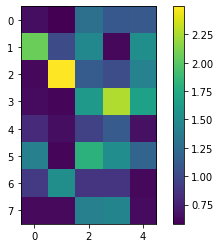

Feedback modulation strength:


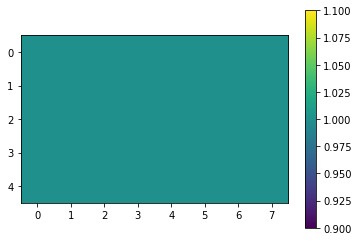

DN Weights (size 2):


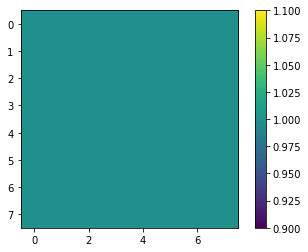

costs
worst violation -10.011412


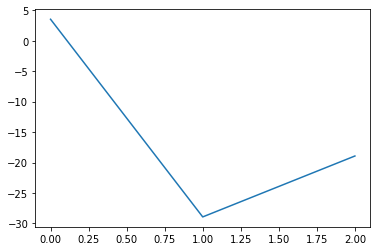

raw_losses


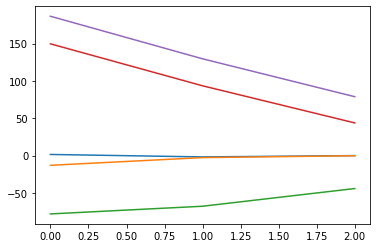

loss penalties (blue for loss, orange for gains


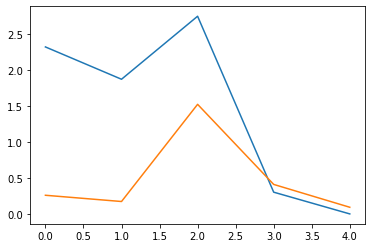

penalty (blue) and reward (orange) exps, by size:


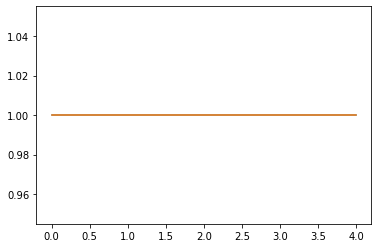

20/20 [==============================] - 21s 1s/step - loss: -2.0161
Epoch 37/1000
20/20 [==============================] - 2s 117ms/step - loss: -2.5999
Epoch 38/1000
20/20 [==============================] - 2s 115ms/step - loss: -0.0522
Epoch 39/1000
20/20 [==============================] - 2s 113ms/step - loss: -0.5318
Epoch 40/1000
20/20 [==============================] - 2s 114ms/step - loss: -5.1276
Epoch 41/1000
20/20 [==============================] - ETA: 0s - loss: 0.3183['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf

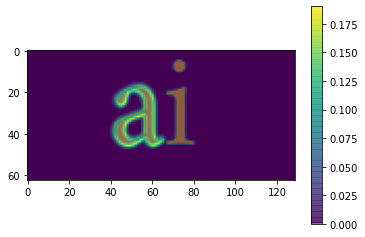

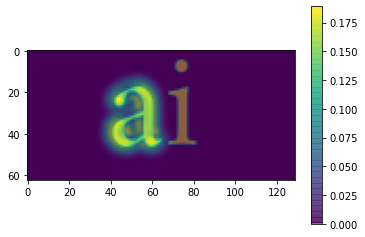

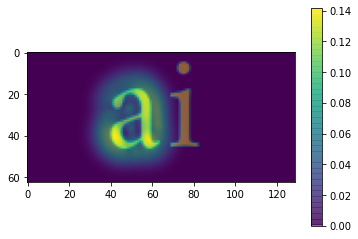


Pair DIFFS:
Pair total cost 23.646082


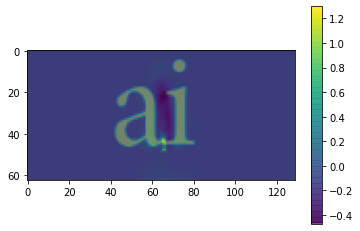

Pair total cost -16.864073


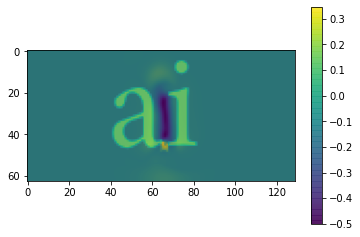

Pair total cost -7.0122337


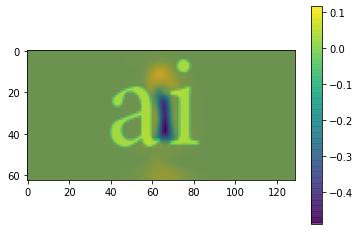

RAW LOSSES for size


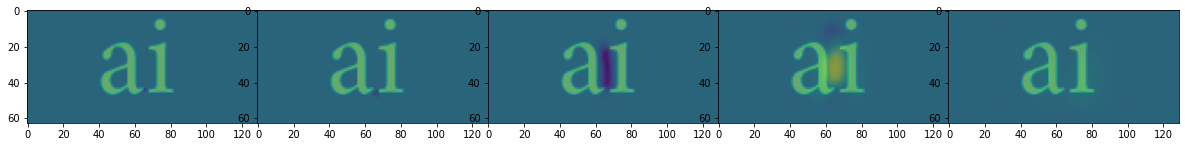

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(1.1920929e-06, shape=(), dtype=float32) total losses: tf.Tensor(2.078182e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(5.030632e-05, shape=(), dtype=float32) total losses: tf.Tensor(0.0003068724, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.023966968, shape=(), dtype=float32) total losses: tf.Tensor(1.2130423, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.43198812, shape=(), dtype=float32) total losses: tf.Tensor(110.7217, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.07598001, shape=(), dtype=float32) total losses: tf.Tensor(44.28675, shape=(), dtype=float32)


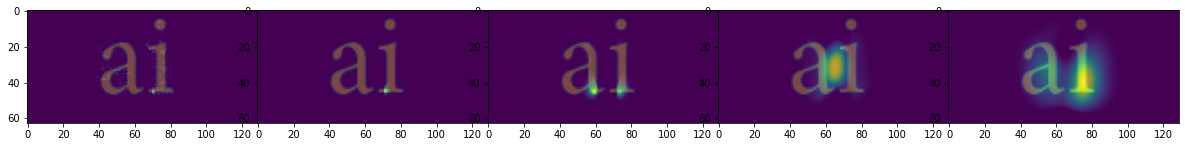

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.26887968, shape=(), dtype=float32) total gain: tf.Tensor(1.2174757, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.2114014, shape=(), dtype=float32) total gain: tf.Tensor(2.6526768, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.49349904, shape=(), dtype=float32) total gain: tf.Tensor(64.19763, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.13436355, shape=(), dtype=float32) total gain: tf.Tensor(13.830334, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.024039172, shape=(), dtype=float32) total gain: tf.Tensor(2.9931593, shape=(), dtype=float32)


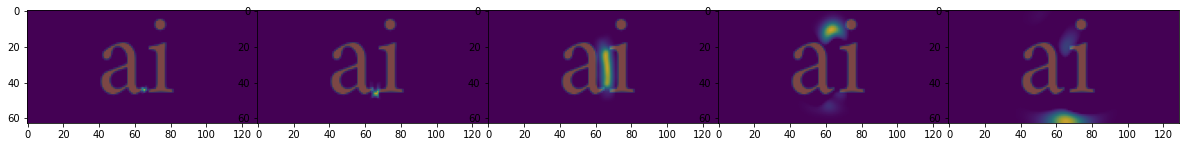

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.9707062, shape=(), dtype=float32) sum tf.Tensor(222.31488, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9961116, shape=(), dtype=float32) sum tf.Tensor(452.32526, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9171104, shape=(), dtype=float32) sum tf.Tensor(422.89093, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.8586998, shape=(), dtype=float32) sum tf.Tensor(711.8002, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.29638496, shape=(), dtype=float32) sum tf.Tensor(283.4156, shape=(), dtype=float32)


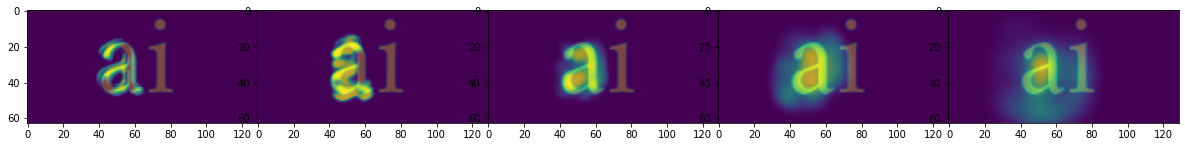

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.9707062, shape=(), dtype=float32) sum tf.Tensor(222.31488, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9961116, shape=(), dtype=float32) sum tf.Tensor(452.32526, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.9171104, shape=(), dtype=float32) sum tf.Tensor(422.89093, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.8586998, shape=(), dtype=float32) sum tf.Tensor(711.8002, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.29638496, shape=(), dtype=float32) sum tf.Tensor(283.4156, shape=(), dtype=float32)


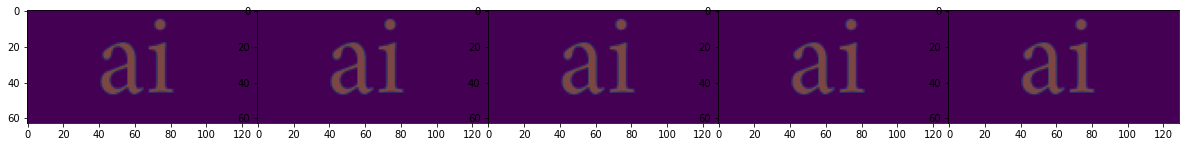

COST of DIFF for size


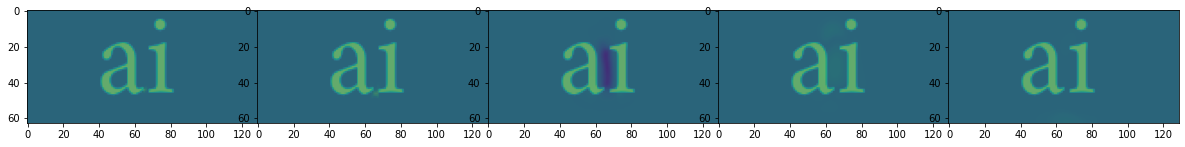

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


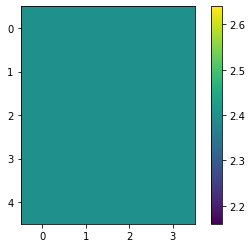

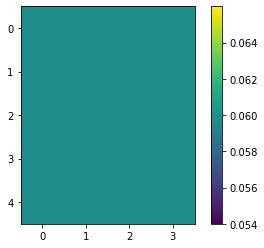

V4 (scales/orientations) exponents [k] and half-points [b]


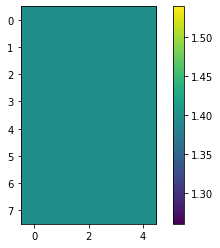

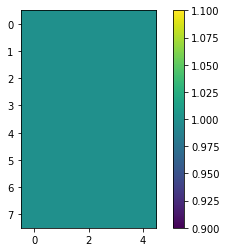

G (scales) exponents [k] and half-points [b]


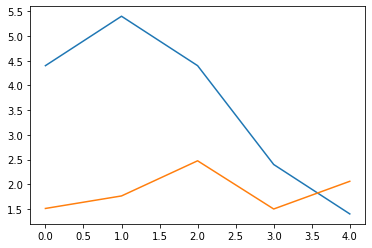

M


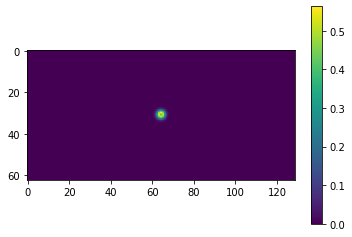

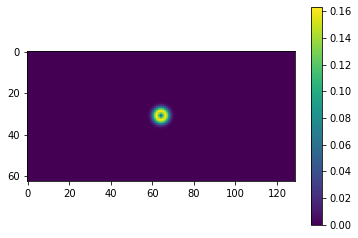

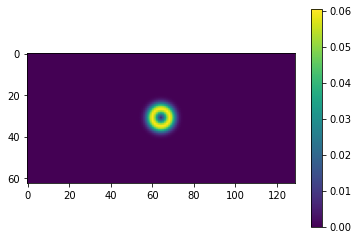

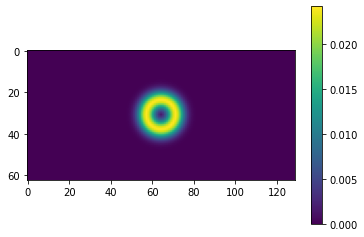

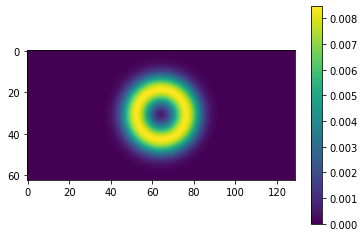

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


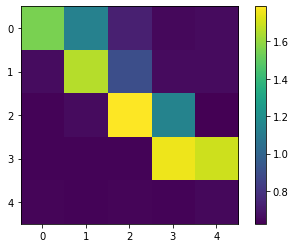

Orientation weights:


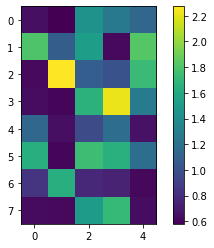

Feedback modulation strength:


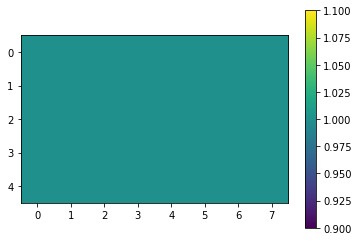

DN Weights (size 2):


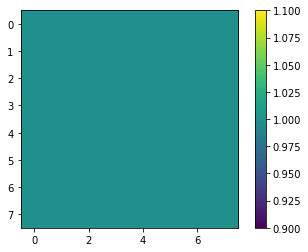

costs
worst violation -9.851839


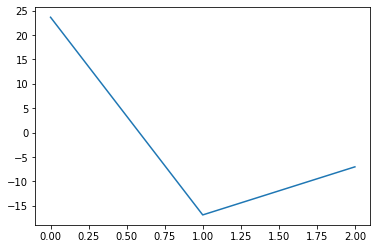

raw_losses


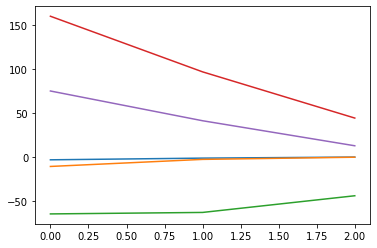

loss penalties (blue for loss, orange for gains


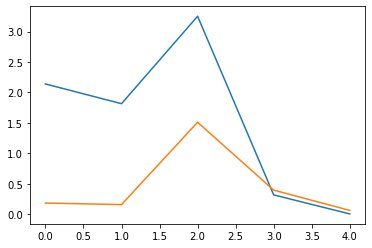

penalty (blue) and reward (orange) exps, by size:


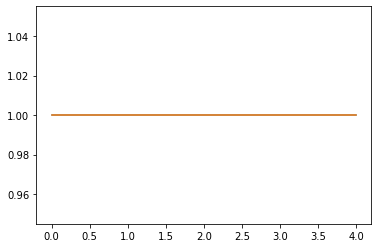

20/20 [==============================] - 21s 1s/step - loss: 0.3183
Epoch 42/1000
20/20 [==============================] - 2s 114ms/step - loss: -3.0390
Epoch 43/1000
20/20 [==============================] - 2s 114ms/step - loss: -5.3002
Epoch 44/1000
20/20 [==============================] - 2s 114ms/step - loss: -7.6648
Epoch 45/1000
20/20 [==============================] - 2s 114ms/step - loss: -6.5262
Epoch 46/1000
20/20 [==============================] - ETA: 0s - loss: -7.3584['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 'tf

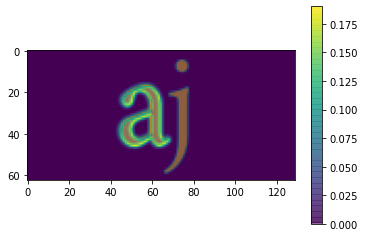

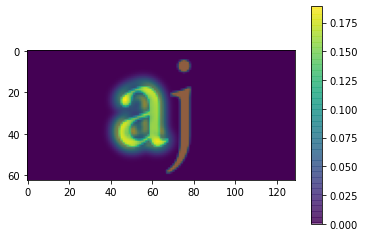

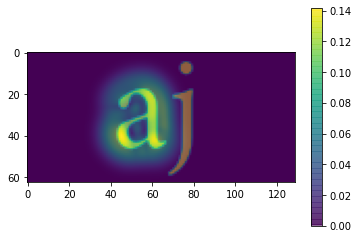


Pair DIFFS:
Pair total cost -16.839064


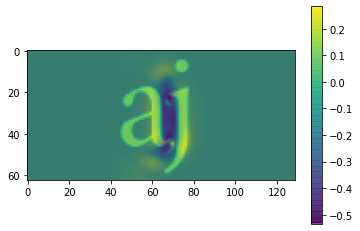

Pair total cost -70.93364


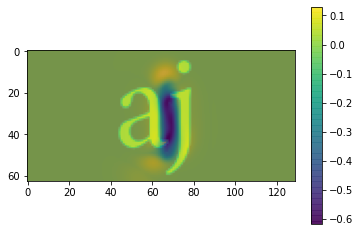

Pair total cost -60.23699


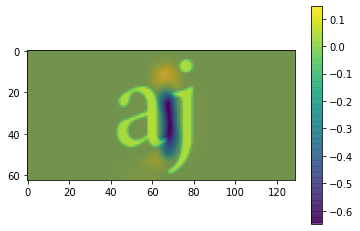

RAW LOSSES for size


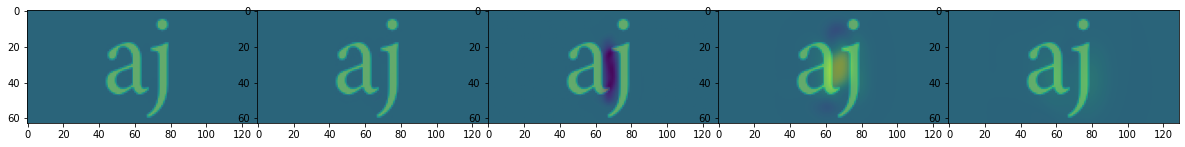

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(2.9802322e-07, shape=(), dtype=float32) total losses: tf.Tensor(1.7121176e-05, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(1.3887882e-05, shape=(), dtype=float32) total losses: tf.Tensor(0.00014125212, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.013672888, shape=(), dtype=float32) total losses: tf.Tensor(1.2689776, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.3457194, shape=(), dtype=float32) total losses: tf.Tensor(119.59814, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.08879496, shape=(), dtype=float32) total losses: tf.Tensor(73.03261, shape=(), dtype=float32)


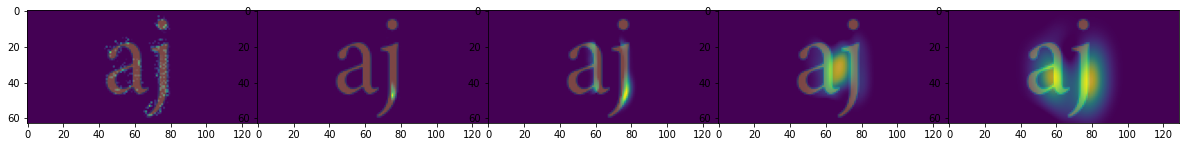

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.0035590604, shape=(), dtype=float32) total gain: tf.Tensor(0.023397489, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.036575228, shape=(), dtype=float32) total gain: tf.Tensor(0.41536778, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.47159833, shape=(), dtype=float32) total gain: tf.Tensor(86.66467, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.123108, shape=(), dtype=float32) total gain: tf.Tensor(17.143244, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.00883621, shape=(), dtype=float32) total gain: tf.Tensor(0.74788415, shape=(), dtype=float32)


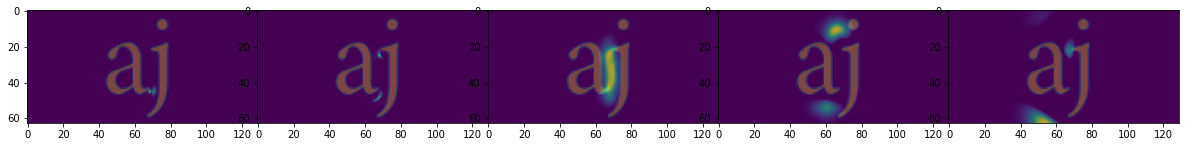

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.9571361, shape=(), dtype=float32) sum tf.Tensor(203.99368, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9992489, shape=(), dtype=float32) sum tf.Tensor(522.4557, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.8631816, shape=(), dtype=float32) sum tf.Tensor(353.73337, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.8011126, shape=(), dtype=float32) sum tf.Tensor(590.1364, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.3034362, shape=(), dtype=float32) sum tf.Tensor(271.57562, shape=(), dtype=float32)


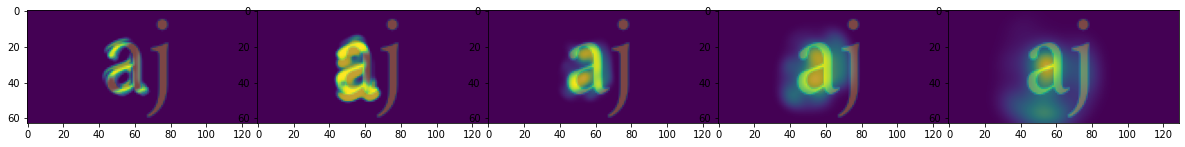

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.9571361, shape=(), dtype=float32) sum tf.Tensor(203.99368, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.9992489, shape=(), dtype=float32) sum tf.Tensor(522.4557, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.8631816, shape=(), dtype=float32) sum tf.Tensor(353.73337, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.8011126, shape=(), dtype=float32) sum tf.Tensor(590.1364, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.3034362, shape=(), dtype=float32) sum tf.Tensor(271.57562, shape=(), dtype=float32)


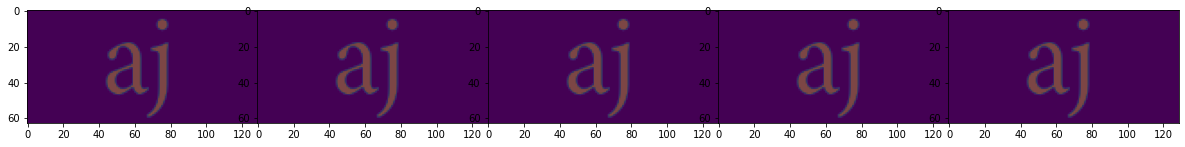

COST of DIFF for size


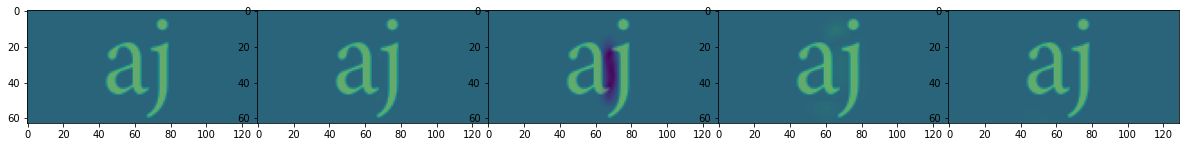

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


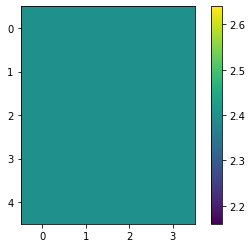

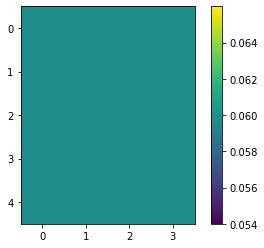

V4 (scales/orientations) exponents [k] and half-points [b]


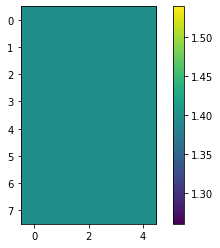

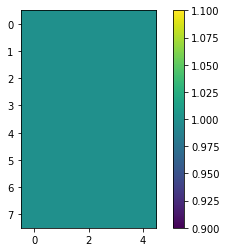

G (scales) exponents [k] and half-points [b]


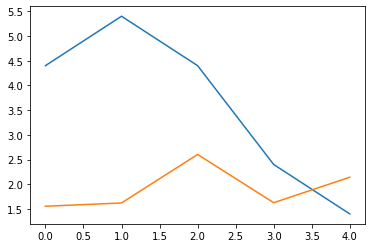

M


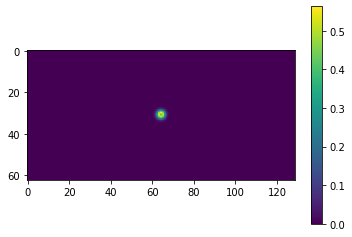

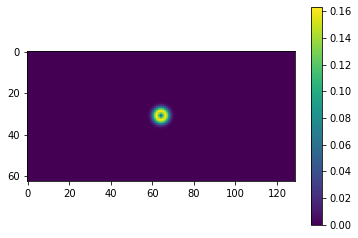

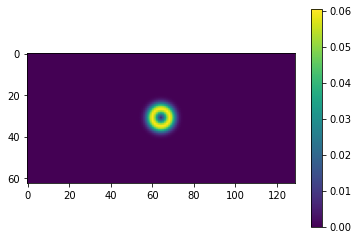

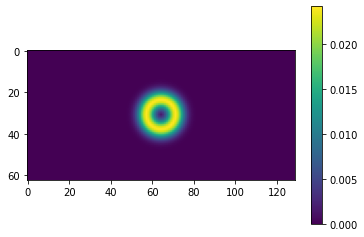

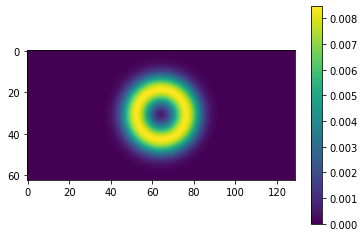

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


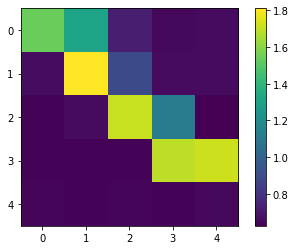

Orientation weights:


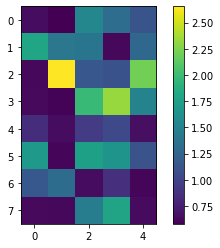

Feedback modulation strength:


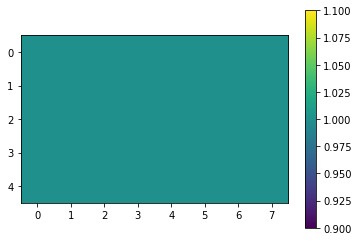

DN Weights (size 2):


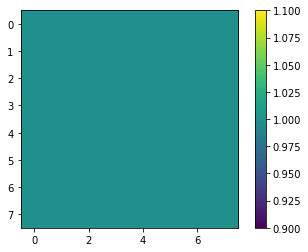

costs
worst violation -10.696648


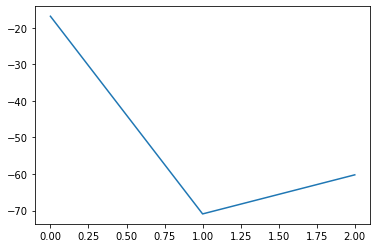

raw_losses


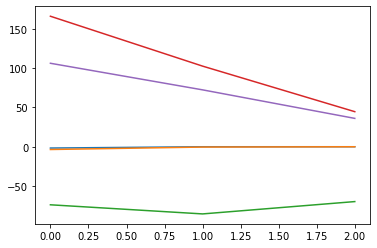

loss penalties (blue for loss, orange for gains


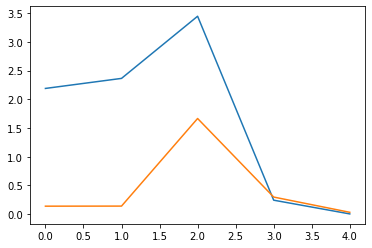

penalty (blue) and reward (orange) exps, by size:


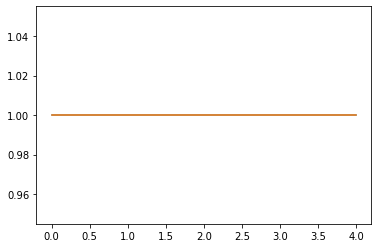

20/20 [==============================] - 21s 1s/step - loss: -7.3584
Epoch 47/1000
20/20 [==============================] - 2s 114ms/step - loss: -8.0362
Epoch 48/1000
20/20 [==============================] - 2s 116ms/step - loss: -0.1472
Epoch 49/1000
20/20 [==============================] - 2s 115ms/step - loss: -9.2864
Epoch 50/1000
20/20 [==============================] - 2s 115ms/step - loss: -9.5850
Epoch 51/1000
20/20 [==============================] - ETA: 0s - loss: -5.8797['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21', 't

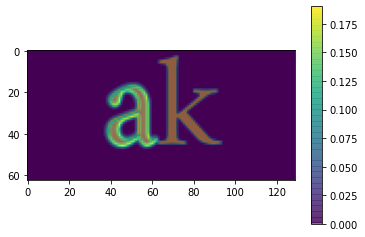

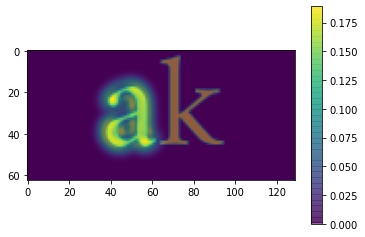

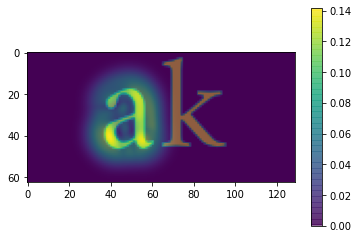


Pair DIFFS:
Pair total cost 1.3158512


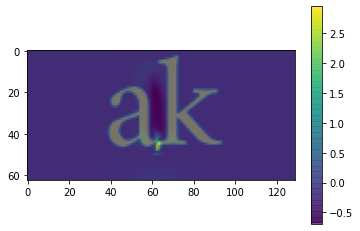

Pair total cost -29.489695


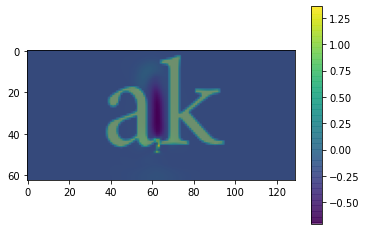

Pair total cost 6.733756


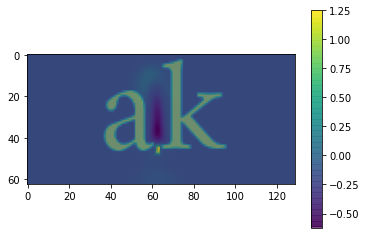

RAW LOSSES for size


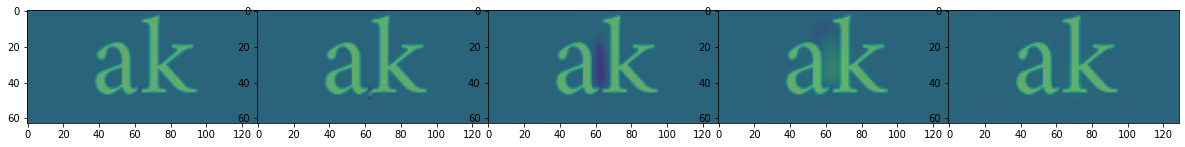

RAW V4 LOSSES for size, without min/max limit
Scale 0 max loss: tf.Tensor(6.055832e-05, shape=(), dtype=float32) total losses: tf.Tensor(0.0002532004, shape=(), dtype=float32)
Scale 1 max loss: tf.Tensor(0.50576556, shape=(), dtype=float32) total losses: tf.Tensor(1.614493, shape=(), dtype=float32)
Scale 2 max loss: tf.Tensor(0.04158151, shape=(), dtype=float32) total losses: tf.Tensor(2.0742757, shape=(), dtype=float32)
Scale 3 max loss: tf.Tensor(0.32071692, shape=(), dtype=float32) total losses: tf.Tensor(94.36008, shape=(), dtype=float32)
Scale 4 max loss: tf.Tensor(0.06938101, shape=(), dtype=float32) total losses: tf.Tensor(41.251183, shape=(), dtype=float32)


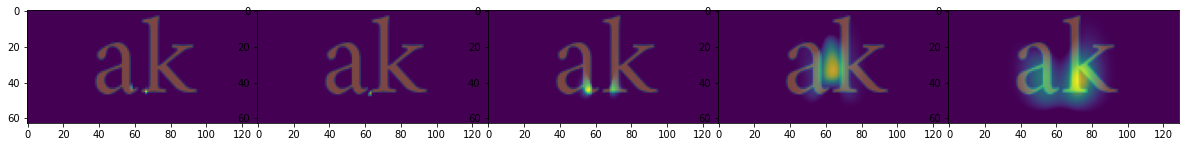

RAW V4 GAINS for size, without min/max limit
Scale 0 max gain: tf.Tensor(0.22766306, shape=(), dtype=float32) total gain: tf.Tensor(1.4600133, shape=(), dtype=float32)
Scale 1 max gain: tf.Tensor(0.4403713, shape=(), dtype=float32) total gain: tf.Tensor(3.6711826, shape=(), dtype=float32)
Scale 2 max gain: tf.Tensor(0.48798767, shape=(), dtype=float32) total gain: tf.Tensor(68.39904, shape=(), dtype=float32)
Scale 3 max gain: tf.Tensor(0.14904852, shape=(), dtype=float32) total gain: tf.Tensor(16.468094, shape=(), dtype=float32)
Scale 4 max gain: tf.Tensor(0.02102033, shape=(), dtype=float32) total gain: tf.Tensor(3.0495403, shape=(), dtype=float32)


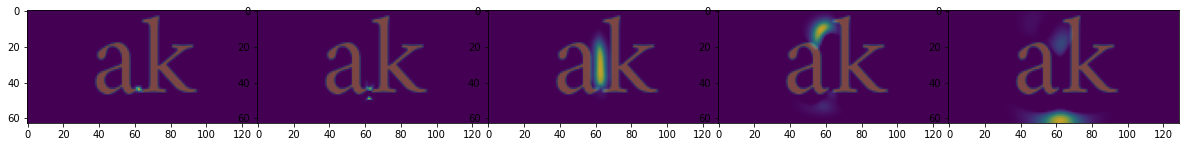

LEFT GLYPH v4 response for size, without min/max limit, 0-3
Channel 0 max tf.Tensor(0.946229, shape=(), dtype=float32) sum tf.Tensor(181.75797, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.99990493, shape=(), dtype=float32) sum tf.Tensor(607.3098, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.7917832, shape=(), dtype=float32) sum tf.Tensor(292.38303, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.80284315, shape=(), dtype=float32) sum tf.Tensor(582.801, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.22240157, shape=(), dtype=float32) sum tf.Tensor(194.86215, shape=(), dtype=float32)


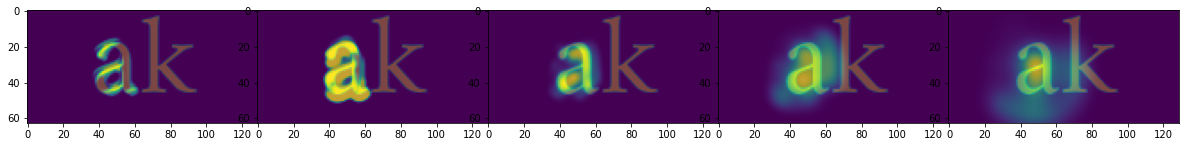

LEFT GLYPH v4 response for size, without min/max limit
Channel 0 max tf.Tensor(0.946229, shape=(), dtype=float32) sum tf.Tensor(181.75797, shape=(), dtype=float32)
Channel 1 max tf.Tensor(0.99990493, shape=(), dtype=float32) sum tf.Tensor(607.3098, shape=(), dtype=float32)
Channel 2 max tf.Tensor(0.7917832, shape=(), dtype=float32) sum tf.Tensor(292.38303, shape=(), dtype=float32)
Channel 3 max tf.Tensor(0.80284315, shape=(), dtype=float32) sum tf.Tensor(582.801, shape=(), dtype=float32)
Channel 4 max tf.Tensor(0.22240157, shape=(), dtype=float32) sum tf.Tensor(194.86215, shape=(), dtype=float32)


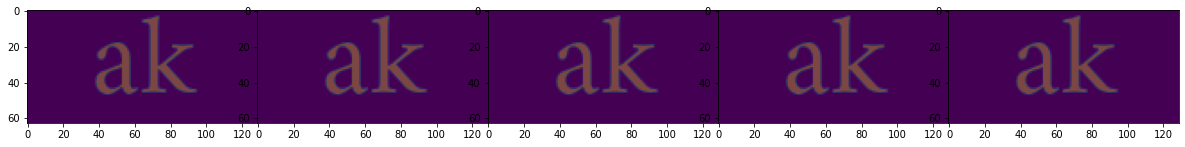

COST of DIFF for size


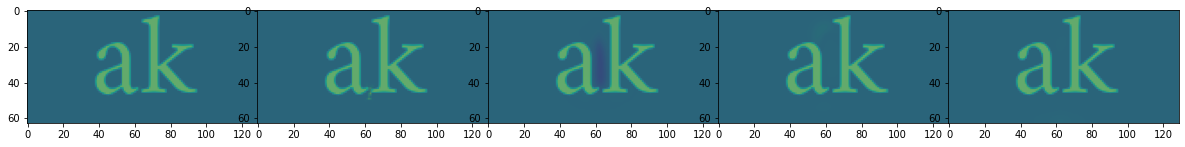

HRA parameters:
---------
V1 (scales/orientations) exponents [k] and half-points [b]


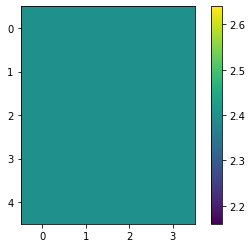

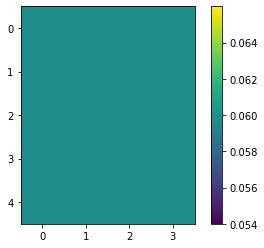

V4 (scales/orientations) exponents [k] and half-points [b]


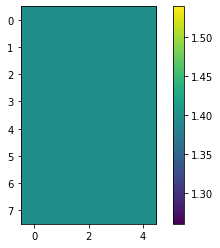

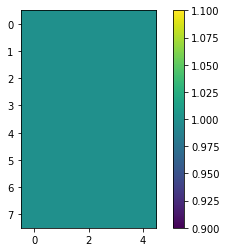

G (scales) exponents [k] and half-points [b]


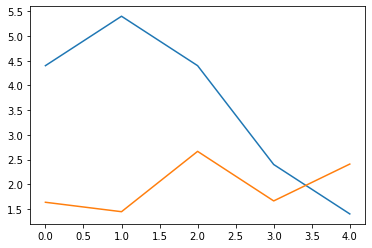

M


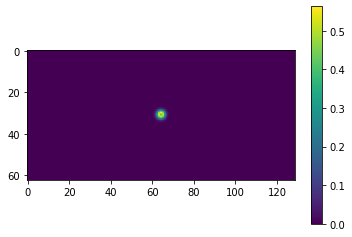

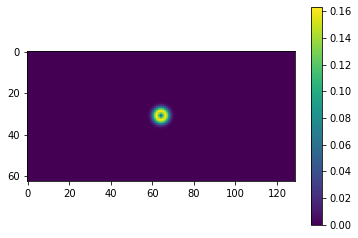

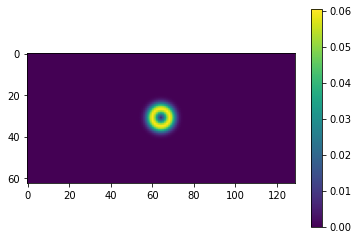

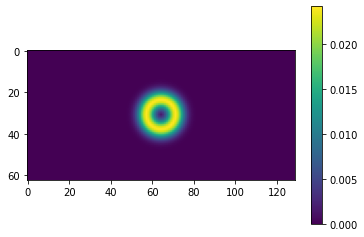

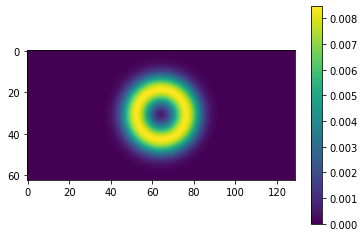

SCALES, WIDTHS, STRENGHTS [0.00310078 0.00852713 0.01627907 0.02713178 0.04651163] 
 [0.00387597 0.00542636 0.00775194 0.01162791 0.01937984] 
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
Linking matrix:
Scale weights:


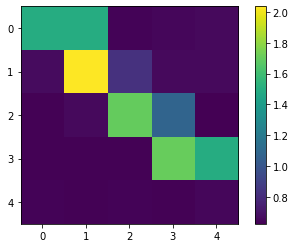

Orientation weights:


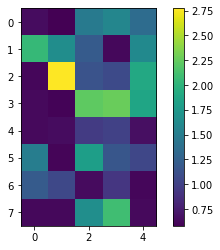

Feedback modulation strength:


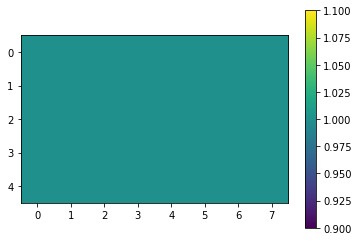

DN Weights (size 2):


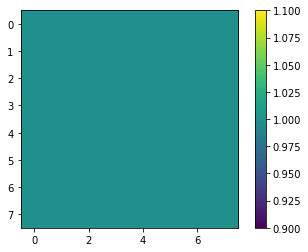

costs
worst violation -30.805546


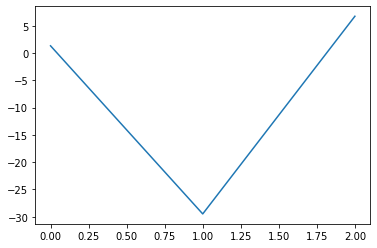

raw_losses


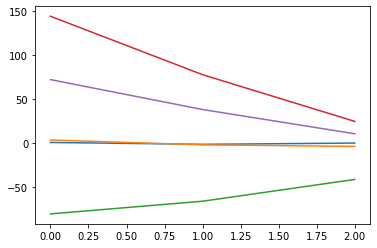

loss penalties (blue for loss, orange for gains


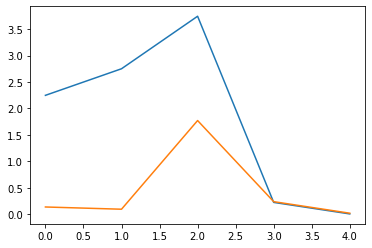

penalty (blue) and reward (orange) exps, by size:


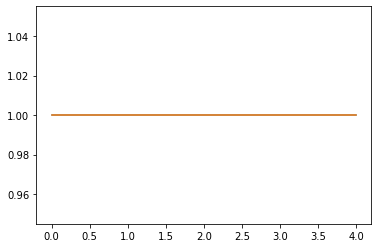

20/20 [==============================] - 22s 1s/step - loss: -5.8797
Epoch 52/1000
20/20 [==============================] - 2s 115ms/step - loss: -14.1651
Epoch 53/1000
20/20 [==============================] - 2s 115ms/step - loss: -3.8180
Epoch 54/1000
20/20 [==============================] - 2s 115ms/step - loss: -3.0022
Epoch 55/1000
20/20 [==============================] - 2s 116ms/step - loss: -10.0285
Epoch 56/1000
20/20 [==============================] - ETA: 0s - loss: -12.7881['left_v1_response', 'right_v1_response', 'tf_op_layer_ComplexAbs_15', 'tf_op_layer_ComplexAbs_16', 'tf_op_layer_AddV2_10', 'v4_layer_5', 'tf_op_layer_ComplexAbs_17', 'tf_op_layer_left_v4_response_5', 'tf_op_layer_right_v4_response_5', 'tf_op_layer_AddV2_11', 'tf_op_layer_pair_v4_response_5', 'tf_op_layer_Sub_20', 'tf_op_layer_pair_diff_5', 'cost_layer_5', 'tf_op_layer_Sub_21', 'tf_op_layer_pair_pixel_cost_5', 'tf_op_layer_pair_total_cost_5', 'tf_op_layer_strided_slice_20', 'tf_op_layer_strided_slice_21',

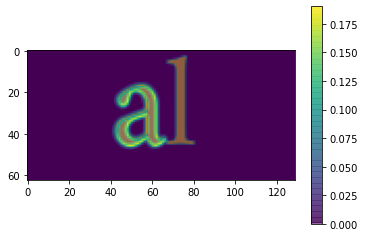

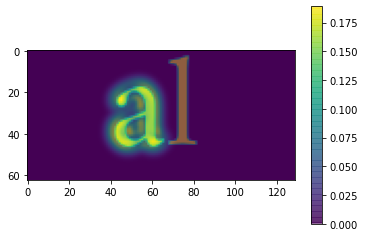

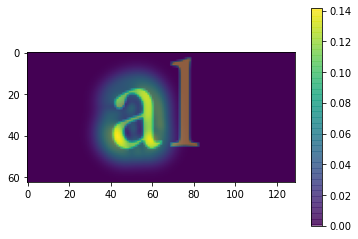


Pair DIFFS:


KeyboardInterrupt: ignored

In [15]:
# 5. Utility functions
eps = np.finfo(np.float32).tiny

def invspa(t):
    return np.log(np.exp(t) - 1).astype(np.float32)

def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

def sp(t):
    return tf.nn.softplus(t)

# 6. Generating G-cell fragments

u, v = np.mgrid[-box_height:box_height,-box_width:box_width].astype(np.float32)
u = u / (2*box_width)
v = v / (2*box_width)
r = np.sqrt(u**2 + v**2)[None, None, :, :]
angle = np.arctan2(u, v)[None, None, :, :] # <b, d, s, o, c, h, w>
angles = np.arange(n_v1_orientations)[:, None, None, None].astype(np.float32)/n_v1_orientations

def make_v4_filters(scales, inner_widths, angle_mask_widths): # Returns masks of shape <o, c, h, w>
    freq_masks = tf.exp(-(r - scales[None, :, None, None])**2 / (2 * (inner_widths[None, :, None, None])**2))
    #freq_masks = (1/(r**2 + eps)) * tf.exp(-(tf.math.log(r + eps) - scales[None, :, None, None])**2 / (2 * inner_widths[None, :, None, None])**2)

    # Uses von-Mises distribution (via Bessel function)
    bp_angle_masks = tf.exp(-angle_mask_widths[:, :, None, None] * tf.cos(angle - pi - pi * angles)) / (2*pi*tf.math.bessel_i0(angle_mask_widths[:, :, None, None]))
    bn_angle_masks = tf.exp(-angle_mask_widths[:, :, None, None] * tf.cos(angle - pi * angles)) / (2*pi*tf.math.bessel_i0(angle_mask_widths[:, :, None, None]))

    bp_masks = (freq_masks) * bp_angle_masks
    bn_masks = (freq_masks) * bn_angle_masks

    # Each bp/bn_mask fragment should add up to exactly one.
    bp_masks_normed = 4*bp_masks / (eps + tf.reduce_sum(bp_masks, [0, 2, 3], keepdims=True))
    bn_masks_normed = 4*bn_masks / (eps + tf.reduce_sum(bn_masks, [0, 2, 3], keepdims=True))

    return tf.clip_by_value(tf.concat([bp_masks_normed, bn_masks_normed], axis=0), -1e12, 1e12)


# 7. V4 layer
class V4Layer(tf.keras.layers.Layer):
    def __init__(self, skip_v4_convolution=False, **kwargs):
        super(V4Layer, self).__init__(**kwargs)

        self.skip_v4_convolution = skip_v4_convolution


        self.v1_hra_k = self.add_weight(shape=((n_v1_scales, n_v1_orientations)),
                                 initializer=tf.keras.initializers.Constant(np.tile(invsp([2.4,2.4,2.4,2.4,2.4])[:, None], [1, n_v1_orientations])), # 1 to .02
                                 name="v1_hra_k",
                                 trainable=False)
        self.v1_hra_b = self.add_weight(shape=((n_v1_scales, n_v1_orientations)),
                                 initializer=tf.keras.initializers.Constant(np.tile(invsp([.06,.06,.06,.06,.06])[:, None], [1, n_v1_orientations])), # 1 to .02
                                 name="v1_hra_b",
                                 trainable=False)

        self.v4_scales_min = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(.1), name="v4_scales_min", trainable=True)
        self.v4_scales_factor = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(1.9), name="v4_scales_factor", trainable=True)
        self.v4_widths_min = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(1.5), name="v4_widths_min", trainable=True)
        self.v4_widths_factor = self.add_weight(shape=(), initializer=tf.keras.initializers.Constant(-.2), name="v4_widths_factor", trainable=True)

        self.v4_scales = self.add_weight(shape=(n_v4_scales),
                                      initializer=tf.keras.initializers.Constant(np.array([.4,1.1,2.1, 3.5,6]).astype(np.float32)/box_width),
                                      #initializer=tf.keras.initializers.Constant(np.array([1.4,1.6,1.75,1.83,1.9]).astype(np.float32)),
                                      name="v4_scales", trainable=False)
        self.v4_widths = self.add_weight(shape=(n_v4_scales),
                                            initializer=tf.keras.initializers.Constant(np.array([.5,0.7,1.,1.5,2.5]).astype(np.float32)/box_width),
                                            #initializer=tf.keras.initializers.Constant(np.array([1.4,1.25,1.15,1.03,.98]).astype(np.float32)),
                                            name="v4_widths", trainable=False)
        self.v4_angle_mask_widths = self.add_weight(shape=(n_v1_orientations, n_v4_scales),
                                                 initializer=tf.keras.initializers.Constant(4.),
                                                 name="v4_angle_mask_widths", trainable=False)
        self.v4_filter_strengths = self.add_weight(shape=(n_v1_orientations, n_v4_scales),
                                               initializer=tf.keras.initializers.Constant(1.),
                                               name="v4_filter_strengths", trainable=False)

        self.v4_hra_k = self.add_weight(shape=(2*n_v1_orientations, n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(np.tile(invsp([1.4, 1.4, 1.4, 1.4, 1.4])[None, :], [2*n_v1_orientations, 1])),
                                 name="v4_hra_k",
                                 trainable=False)
        self.v4_hra_b = self.add_weight(shape=(2*n_v1_orientations, n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(np.tile(invsp([1,1,1,1,1])[None, :], [2*n_v1_orientations, 1])),
                                 name="v4_hra_b",
                                 trainable=False)


        # Each ring should only be able to draw from 
        self.v1_v4_scale_weights = self.add_weight(shape=(n_v1_scales, n_v4_scales),
                                 initializer=tf.keras.initializers.Constant((eps + np.triu(np.ones((n_v1_scales, n_v4_scales))).astype(np.float32) * .5**toeplitz(np.zeros(n_v1_scales), np.arange(n_v4_scales)))),
                                 name="v1_v4_scale_weights",
                                 trainable=True)
        self.v1_v4_orientation_weights = self.add_weight(shape=(2*n_v1_orientations, n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(invsp(1.)),
                                 name="v1_v4_orientation_weights",
                                 trainable=True)
        
        self.g_hra_k = self.add_weight(shape=(n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(invsp([4.4, 5.4, 4.4, 2.4, 1.4])),
                                 name="g_hra_k",
                                 trainable=False)
        self.g_hra_b = self.add_weight(shape=(n_v4_scales),
                                 initializer=tf.keras.initializers.Constant(invsp([1.5, 2., 2.5, 1.5, 1.0]).astype(np.float32)),
                                 name="g_hra_b",
                                 trainable=True)

        self.feedback_modulation_strength = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations, 1, 1),
                                 initializer=tf.keras.initializers.Constant(invsp(1.)),
                                 name="feedback_modulation_strength",
                                 trainable=True)


        self.b_dn_b = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(invsp(1.5)),
                                 name="b_dn_b",
                                 trainable=True)
        self.b_dn_k = self.add_weight(shape=(n_v1_scales, 2*n_v1_orientations),
                                 initializer=tf.keras.initializers.Constant(invsp(4.5)),
                                 name="b_dn_k",
                                 trainable=True)

        # We would want the normalization pool to mostly include, for each size/orientation, the opposite orientation.
        # We would also want to include smaller sizes. But perhaps that's not so important?

        basic_dn_matrix = np.zeros((n_v1_scales, 2*n_v1_orientations, n_v1_scales, 2*n_v1_orientations)).astype(np.float32)

        # The first ones are the ones that count towards the second
        for s1 in range(n_v1_scales):
            for o1 in range(2*n_v1_orientations):
                for s2 in range(n_v1_scales):
                    for o2 in range(2*n_v1_orientations):
                        s_distance = np.exp(-(s1 - s2)**2)
                        basic_dn_matrix[s1, o1, s2, o2] = s_distance

        self.b_dn_weights = self.add_weight(shape=((n_v1_scales, 2*n_v1_orientations, n_v1_scales, 2*n_v1_orientations)),
                                 initializer=tf.keras.initializers.Constant(basic_dn_matrix.astype(np.float32)),
                                 name="b_dn_weights",
                                 trainable=True)


    def print_weights(self):
        print("HRA parameters:")
        print("---------")
        print("V1 (scales/orientations) exponents [k] and half-points [b]")
        plt.imshow(sp(self.v1_hra_k))
        plt.colorbar()
        plt.show()
        plt.imshow(sp(self.v1_hra_b))
        plt.colorbar()
        plt.show()
        print("V4 (scales/orientations) exponents [k] and half-points [b]")
        plt.imshow(sp(self.v4_hra_k))
        plt.colorbar()
        plt.show()
        plt.imshow(sp(self.v4_hra_b))
        plt.colorbar()
        plt.show()
        print("G (scales) exponents [k] and half-points [b]")
        plt.plot(sp(self.g_hra_k))
        plt.plot(sp(self.g_hra_b))
        plt.show()

        print("M")
        v4_filters = (make_v4_filters(self.v4_scales, self.v4_widths, self.v4_angle_mask_widths))[None, None, None, ...]
        for i in range(n_v4_scales):
            plt.imshow(tf.reduce_sum(v4_filters[0, 0, 0, :, i, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                            int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], [0]))
            plt.colorbar()
            plt.show()

        print("SCALES, WIDTHS, STRENGHTS", self.v4_scales.numpy(), "\n", self.v4_widths.numpy(), "\n", self.v4_filter_strengths.numpy())

        print("Linking matrix:")
        print("Scale weights:")
        plt.imshow(sp(self.v1_v4_scale_weights))
        plt.colorbar()
        plt.show()
        print("Orientation weights:")
        plt.imshow(sp(self.v1_v4_orientation_weights))
        plt.colorbar()
        plt.show()

        print("Feedback modulation strength:")
        plt.imshow(sp(self.feedback_modulation_strength)[:, :, 0, 0])
        plt.colorbar()
        plt.show()

        print("DN Weights (size 2):")
        plt.imshow(self.b_dn_weights[2, :, 2, :])
        plt.colorbar()
        plt.show()

    def hra_v1(self, i):
        k = sp(self.v1_hra_k[None, None, :, :, None, None])
        b = sp(self.v1_hra_b[None, None, :, :, None, None])
        return ((i + eps) ** k) / (eps + b**k + (i + eps) ** k)

    def hra_v4(self, i):
        return i
        k = sp(self.v4_hra_k[None, None, :, :, None, None])
        b = sp(self.v4_hra_b[None, None, :, :, None, None])
        return 2*((i + eps) ** k) / (eps + b**k + (i + eps) ** k)

    def hra_g(self, i):
        k = sp(self.g_hra_k[None, None, :, None, None])
        b = sp(self.g_hra_b[None, None, :, None, None])
        return ((i + eps) ** k) / (eps + b**k + (i + eps) ** k)

    def call(self, inputs):
        v1c = self.hra_v1(tf.abs(inputs))
    
        b_balanced = tf.pad(tf.concat([v1c]*2, axis=3), [[0, 0], [0, 0], [0, 0], [0, 0],
                                [int(np.ceil(box_height / 2)), int(box_height / 2)],
                                [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')
        
        b_balanced_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(b_balanced, 0.), [4, 5]))
        
        v4_filters = (make_v4_filters(self.v4_scales, self.v4_widths, self.v4_angle_mask_widths) * tf.concat([self.v4_filter_strengths] * 2, axis=0)[..., None, None])[None, None, None, ...]
        
        v4_filters_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(v4_filters, 0.), [5, 6]))
        
        v4_activations_0_by_s_o = tf.nn.relu(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(v4_filters_fft * b_balanced_fft[:, :, :, :, None, :, :]), [5, 6])))
        
        v4_activations_0 = self.hra_v4(tf.einsum("bdsochw,sc->bdochw", v4_activations_0_by_s_o, eps + tf.nn.relu(self.v1_v4_scale_weights))) # hra_v4
        
        G_0 = self.hra_g(tf.einsum("bdochw,oc->bdchw", v4_activations_0, tf.nn.relu(self.v1_v4_orientation_weights) / (eps + tf.reduce_mean(tf.nn.relu(self.v1_v4_orientation_weights), axis=[0], keepdims=True) ))) 
        
        # We split the G_0 response by orientation, just like they came in.
        v4_feedback = tf.einsum("bdchw,oc->bdochw", G_0, self.v1_v4_orientation_weights)
    
        # For each V4 (ochw), convolute with its counterpart. This produces the opposite.
        v4_feedback_fft = tf.signal.fft2d(tf.signal.ifftshift(tf.complex(v4_feedback, 0.), [4, 5]))
        v4_filters_fft_inverse = tf.roll(v4_filters_fft[:, :, 0, :, :, :, :], [n_v1_orientations], [2])
        v4_feedback_deconvolved = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(v4_feedback_fft * v4_filters_fft_inverse), [4, 5]))
        
        # For each counterpart, figure out how much it should contribute to the feedback at each scale.
        b_feedback = tf.einsum("bdochw,sc->bdsohw", v4_feedback_deconvolved, tf.nn.relu(self.v1_v4_scale_weights))
    
        b_modulated = b_balanced * (1. + self.feedback_modulation_strength * b_feedback)
        
        b_normalization_pools = tf.einsum("bdsohw,sopq->bdpqhw", (b_modulated + eps) ** sp(self.b_dn_k[None, None, :, :, None, None]), self.b_dn_weights)
        
        b_normalized = 2 * (b_modulated + eps) ** sp(self.b_dn_k[None, None, :, :, None, None]) / (sp(self.b_dn_b[None, None, :, :, None, None]) ** sp(self.b_dn_k[None, None, :, :, None, None]) + b_normalization_pools)
        
        b_normalized_fft = tf.signal.fft2d(tf.complex(tf.signal.ifftshift(b_normalized, [4, 5]), 0.))
        
        v4_activations_1_by_s_o = tf.nn.relu(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(v4_filters_fft * b_normalized_fft[:, :, :, :, None, :, :]), [5, 6])))
        
        v4_activations_1 = self.hra_v4(tf.einsum("bdsochw,sc->bdochw", v4_activations_1_by_s_o, tf.nn.relu(self.v1_v4_scale_weights)))
        
        G_1 = self.hra_g(tf.einsum("bdochw,oc->bdchw", v4_activations_1, self.v1_v4_orientation_weights))

        return G_0[:, :, None, None, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                            int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))] 

# 8. Cost layer
class CostLayer(tf.keras.layers.Layer): # These are like the V1 complex edges
    def __init__(self, **kwargs):
        super(CostLayer, self).__init__(**kwargs)
        # <b, s, o, h, w, d>
        self.wp = self.add_weight(shape=(n_v4_scales), # Losses
                                 initializer=tf.keras.initializers.Constant(invsp([1.5, .9, 1.23, 0.27, 0.01])),
                                 name="wp",
                                 trainable=True)
        self.wn = self.add_weight(shape=(n_v4_scales), # Gains
                                 initializer=tf.keras.initializers.Constant([0.13, 0.24, 0.48, 0.22, 0.03]),
                                 name="wn",
                                 trainable=True)
        self.penalty_exps = self.add_weight(shape=((1, 1, 1, 1, n_v4_scales, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                 name="penalty_exps",
                                 trainable=True)
        self.reward_exps = self.add_weight(shape=((1, 1, 1, 1, n_v4_scales, 1, 1)),
                                 initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                 name="reward_exps",
                                 trainable=True)

    def norm(self, i):
        """Normalize the weights.
        This regularization is necessary to keep the optimizer from simply making the weights tiny."""

        v = tf.cumsum(sp(1e3*i)/1e3, axis=0, reverse=True)
        wpv = tf.reduce_sum(tf.cumsum(sp(1e3*self.wn)/1e3, axis=0, reverse=True) + tf.cumsum(sp(1e3*self.wp)/1e3, axis=0, reverse=True))
        v = sp(i)
        #v = tf.exp(i)
        #wpv = tf.reduce_sum(tf.exp(self.wn) + tf.exp(self.wp))

        return v[None, None, None, None, :, None, None] #/ wpv

    def print_weights(self):
        print("loss penalties (blue for loss, orange for gains")
        plt.plot(self.norm(self.wp)[0, 0, 0, 0, :, 0, 0])
        plt.plot(self.norm(self.wn)[0, 0, 0, 0, :, 0, 0])
        plt.show()
        print("penalty (blue) and reward (orange) exps, by size:")
        plt.plot(sp(self.penalty_exps)[0, 0, 0, 0, :, 0, 0])
        plt.plot(sp(self.reward_exps)[0, 0, 0, 0, :, 0, 0])
        plt.show()

    def call(self, inputs):
        penalties = tf.nn.relu(inputs) * self.norm(self.wp)

        rewards = tf.nn.relu(-inputs) * (self.wn)[None, None, None, None, :, None, None]  # Such that a very strong large grouping is equivalent to a medium-strong smaller grouping

        #total_penalties = tf.reduce_sum((eps + tf.reduce_sum(penalties, [5, 6], keepdims=True)) ** sp(self.penalty_exps), [2, 3, 4, 5, 6])

        #mean_rewards = (eps + tf.reduce_sum(rewards, [2,3,4,5,6])) / (eps + tf.reduce_sum(tf.nn.relu(-inputs), [2,3,4,5,6]))

        #total_rewards_deviation = (eps + tf.abs(mean_rewards - self.desired_total_grouping))**sp(self.desired_total_grouping_deviation_exponent)

        return (penalties, rewards) #, total_rewards_deviation, total_penalties, mean_rewards)

# 9. Set up the actual math

def get_pair_violation(left_v1_response, right_v1_response):
    """Runs the V1 responses through the V4 layer, weights the pair differences via the CostLayer,
    and then returns the worst violation of the "cost-must-be-lowest-for-optimal-distance" principle
    which is then passed to the optimizer."""

    # Feed V1 responses through the V4 layer
    v4 = V4Layer(False)
    left_v4_response = tf.identity(v4(tf.abs(left_v1_response)), "left_v4_response")
    right_v4_response = tf.identity(v4(tf.abs(right_v1_response)), "right_v4_response")
    pair_v4_response = tf.identity(v4(tf.abs(left_v1_response + right_v1_response)), "pair_v4_response")

    # Compute gains and losses in V4 (of pair, relative to standalone letters).
    #pair_diff = tf.identity(tf.math.log((left_v4_response + right_v4_response + eps) / (pair_v4_response + eps)), "pair_diff")
    pair_diff = tf.identity(left_v4_response + right_v4_response - pair_v4_response, "pair_diff")

    # Compute penalty/reward values for each pair_diff
    cost = CostLayer()
    (pair_pixel_penalties, pair_pixel_rewards) = cost(pair_diff)
    
    pair_pixel_cost = tf.identity(pair_pixel_penalties - pair_pixel_rewards, "pair_pixel_cost")

    # Sum over all channels and pixels to yield one total cost per <pair, sample_distance>
    total_pair_cost = tf.reduce_sum(pair_pixel_cost, [2,3,4,5,6], name="pair_total_cost") 
    #
    # Find worst violation of the well
    up_first_ness = (total_pair_cost[:, 1] - total_pair_cost[:, 0])
    down_second_ness = (total_pair_cost[:, 1] - total_pair_cost[:, 2])
    worst_violation = tf.reduce_max(tf.stack([up_first_ness, down_second_ness]), name="worst_violation")

    # Both pair_pixel_penalties and pair_pixel_rewards should only get bigger with more proximity
    #penalty_nonmonotonicity = tf.reduce_sum(tf.nn.relu(pair_total_penalties[:, 1:] - pair_total_penalties[:, 0:-1]))
    #reward_nonmonotonicity = tf.reduce_sum(tf.nn.relu(pair_total_rewards[:, 1:] - pair_total_rewards[:, 0:-1]))

    return worst_violation # + penalty_nonmonotonicity + reward_nonmonotonicity

# 10. Set up Keras model and run

def get_keras_model():
    # The translated raw images aren't used in the model, they're just for visualization purposes ...
    left_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='left_image')
    right_image = tf.keras.Input(shape=(n_sample_distances, box_height, box_width), name='right_image')

    # ... but the translated V1 responses are:
    left_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='left_v1_response', dtype=tf.complex64)
    right_v1_response = tf.keras.Input(shape=(n_sample_distances, n_v1_scales, n_v1_orientations, box_height, box_width), name='right_v1_response', dtype=tf.complex64)

    # This calls the V4 layer, the penalty/reward layer, and finds the max cost
    total_violation = tf.identity(get_pair_violation(left_v1_response, right_v1_response), "total_violation")

    return tf.keras.Model(inputs=[left_v1_response, right_v1_response, left_image, right_image], outputs=(total_violation))

class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, interval):
        self.dataset = dataset
        self.interval = interval
        self.current_data = None

    def get_val(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        output = tf.keras.backend.function(self.model.inputs, [l.output])([self.current_data["left_v1_response"],
                                                                           self.current_data["right_v1_response"],
                                                                           self.current_data["left_image"],
                                                                           self.current_data["right_image"]])[0]
        return output

    def get_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in self.model.layers if l.name.find(name) >= 0][0]
        l.print_weights()

    def on_epoch_end(self, epoch, logs=None):
        # Only show this stuff every [interval] batches
        if epoch % self.interval != 0:
            return

        print([l.name for l in self.model.layers])
        print(self.model.inputs)
        self.current_data, _ = next(self.dataset) #list(self.dataset.take(1).as_numpy_iterator())[0]
        pair_images = self.current_data["left_image"] + self.current_data["right_image"]

        plt.imshow(pair_images[0, 0, :, :])
        plt.imshow(tf.reduce_sum(tf.abs(self.current_data["left_v1_response"][0, 0, 0, :, :, :]), [0]), alpha=.6)
        plt.colorbar()
        plt.show()
        plt.imshow(pair_images[0, 1, :, :])
        plt.imshow(tf.reduce_sum(tf.abs(self.current_data["left_v1_response"][0, 1, 2, :, :, :]), [0]), alpha=.6)
        plt.colorbar()
        plt.show()
        plt.imshow(pair_images[0, 2, :, :])
        plt.imshow(tf.reduce_sum(tf.abs(self.current_data["left_v1_response"][0, 2, n_v1_scales - 2, :, :, :]), [0]), alpha=.6)
        plt.colorbar()
        plt.show()

        print("\nPair DIFFS:")
        pair_cost = self.get_val("pair_pixel_cost")
        print("Pair total cost", self.get_val("pair_total_cost")[0, 0])
        plt.imshow(pair_images[0, 0, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 0, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Pair total cost", self.get_val("pair_total_cost")[0, 1])
        pair_cost = self.get_val("pair_pixel_cost")
        plt.imshow(pair_images[0, 1, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 1, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Pair total cost", self.get_val("pair_total_cost")[0, 2])
        pair_cost = self.get_val("pair_pixel_cost")
        plt.imshow(pair_images[0, 2, :, :], alpha=1)
        plt.imshow(tf.reduce_sum(pair_cost, [2, 3, 4], keepdims=True)[0, 2, 0, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()

        fs = 16
        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        pair_diff = self.get_val("pair_diff")
        maxv = tf.reduce_max(pair_diff)
        minv = tf.reduce_min(pair_diff)
        ex = max(abs(maxv), abs(minv))
        print("RAW LOSSES for size")
        for j in range(n_v4_scales):
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(pair_diff[0, 1, 0, 0, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
        plt.show()

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("RAW V4 LOSSES for size, without min/max limit")
        for j in range(n_v4_scales):
            print("Scale", j, "max loss:", tf.reduce_max(tf.nn.relu(pair_diff[0, 1, 0, 0, j, :, :])), "total losses:", tf.reduce_sum(tf.nn.relu(pair_diff[0, 1, 0, 0, j, :, :])))
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(tf.nn.relu(pair_diff[0, 1, 0, 0, j, :, :]), alpha=0.7)
        plt.show()

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("RAW V4 GAINS for size, without min/max limit")
        for j in range(n_v4_scales):
            print("Scale", j, "max gain:", tf.reduce_max(tf.nn.relu(-pair_diff[0, 1, 0, 0, j, :, :])), "total gain:", tf.reduce_sum(tf.nn.relu(-pair_diff[0, 1, 0, 0, j, :, :])))
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(tf.nn.relu(-pair_diff[0, 1, 0, 0, j, :, :]), alpha=0.7)
        plt.show()

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("LEFT GLYPH v4 response for size, without min/max limit, 0-3")
        for j in range(n_v4_scales):
            print("Channel", j, "max", tf.reduce_max(self.get_val("left_v4_response")[0, 1, 0, 0, j, :, :]), "sum", tf.reduce_sum(self.get_val("left_v4_response")[0, 1, 0, 0, j, :, :]))
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            #ax[j].imshow(self.get_val("left_v4_response")[0, 1, 0, 0, j, :, :], alpha=0.7)
            ax[j].imshow(tf.reduce_sum(self.get_val("left_v4_response")[0, 1, 0, 0:3, j, :, :], [0]), alpha=0.7)
            #ax[j].imshow(tf.reduce_sum(self.get_val("left_v4_response")[0, 1, j, 0:3, 0, :, :], [0]), alpha=0.7)
        plt.show()

        figsize = (fs * 1 * box_width / 100, fs * n_v4_scales * box_height / 100)
        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        print("LEFT GLYPH v4 response for size, without min/max limit")
        for j in range(n_v4_scales):
            print("Channel", j, "max", tf.reduce_max(self.get_val("left_v4_response")[0, 1, 0, 0, j, :, :]), "sum", tf.reduce_sum(self.get_val("left_v4_response")[0, 1, 0, 0, j, :, :]))
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(tf.reduce_sum(self.get_val("left_v4_response")[0, 1, :, 3:, j, :, :], [0,1]), alpha=0.7)
            #ax[j].imshow(tf.reduce_sum(self.get_val("left_v4_response")[0, 1, j, :, 0, :, :], [0]), alpha=0.7)
            #ax[j].imshow(tf.reduce_sum(self.get_val("left_v4_response")[0, 1, j, 3:, 0, :, :], [0]), alpha=0.7)
        plt.show()

        fig, ax = plt.subplots(1, n_v4_scales, gridspec_kw={'wspace':0, 'hspace':0}, figsize=figsize)
        maxv = tf.reduce_max(pair_cost)
        minv = tf.reduce_min(pair_cost)
        ex = max(abs(maxv), abs(minv))
        print("COST of DIFF for size")
        for j in range(n_v4_scales):
            ax[j].imshow(pair_images[0, 1, :, :], alpha=1)
            ax[j].imshow(pair_cost[0, 1, 0, 0, j, :, :], alpha=0.7, vmin=-ex, vmax=ex)
        plt.show()

        self.print_weights("v4_layer")

        print("costs")
        print("worst violation", self.get_val("worst_violation"))
        plt.plot(np.transpose(self.get_val("pair_total_cost")))
        plt.show()

        print("raw_losses")
        plt.plot(tf.reshape(tf.einsum("bdsoc->dbsoc", tf.reduce_sum(pair_diff, [5,6])), [n_sample_distances, batch_size*n_v4_scales]))
        plt.show()

        self.print_weights("cost_layer")

model = get_keras_model()
model.compile(loss=(lambda _, c: c), optimizer=tf.keras.optimizers.Adam(.02))

testing = 0

prepared_dataset = translated_dataset.shuffle(batch_size).batch(batch_size).prefetch(batch_size)

if True:
    history = model.fit(prepared_dataset,
                        callbacks=[MonitorProgressCallback(prepared_dataset.as_numpy_iterator(), 1 if testing else 5)],
                        epochs=(1 if testing else 1000),
                        steps_per_epoch=(1 if testing else 20), use_multiprocessing=False)

In [0]:
scales = np.array([1.4,1.6,1.75,1.83,1.9])
inner_widths = np.array([1.4,1.25,1.15,1.03,0.98]) # Making these bigger shrinks the circle.
#scales = np.log(m) - inner_widths**2
freq_masks = (1/(r**2 + eps)) * np.exp(-(np.log(r + eps) - scales[None, :, None, None])**2 / (2 * inner_widths[None, :, None, None])**2)
for i in range(n_v4_scales):
    print("i", i, "total = ", np.sum(freq_masks[0, i, :, :]))
    plt.imshow(freq_masks[0, i, :, :])
    plt.colorbar()
    plt.show()
print("AND THE TOTAL")
plt.imshow(np.sum(freq_masks[0, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                            int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], (0)))
plt.colorbar()
plt.show()